In [11]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../Coding')
from itertools import combinations
from Algorithms import pattern_count
import time
from Algorithms import NewAlgRanking_19_20211216 as newalg
from Algorithms import NaiveAlgRanking_4_20211213 as naivealg
import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import NewAlgRanking_definition2_13_20220509 as newalg2
from Algorithms import NaiveAlgRanking_definition2_5_20220506 as naivealg2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 15
f_size = (14, 8)

In [ ]:
def string2num(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                p.append(int(item))
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        p.append(int(item))
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
    else:
        # print(tuples_idx)
        # for id in tuples_idx:
        #     print(id, shap_values.values[id][-1])
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        output_file.write(str(avg))
        print("group {} size {}".format(group, len(tuples_idx)))
        print(avg)


def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    if size_topk < Lowerbounds[0]:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True


def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    lowerbound = alpha * size_whole_data * k / len(data)
    print(size_whole_data, size_topk, lowerbound)
    if size_topk < lowerbound:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True

def plot_distribution_number(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    group_value_dis = [s[i] if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    whole_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    other_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i] if i in s else 0 for i in x_list]


    s = ranked_data[:k][attribute].value_counts().sort_index()
    topkdis = [s[i] if i in s else 0 for i in x_list]

    index = np.arange(len(x_list))
    bar_width = 0.2

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(index, x_list)

    plt.ylabel('number of tuples')
    plt.xlabel('value of attribute ' + attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()

def plot_distribution_ratio(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    print(x_list)
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    total = sum(s)
    whole_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    other_data_dis = [s[i]/total if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i]/total if i in s else 0 for i in x_list]
    bar_width = 0.30

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[4], label="group")
    # plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    # plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    # plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width, topkdis, bar_width,  color=color[0], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    plt.xticks(index + bar_width/2, x_list)
    plt.ylabel('ratio')
    plt.xlabel('value of attribute '+attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=28)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    # plt.show()
    return plt



# student data

In [90]:

all_attributes = ['school_C', 'sex_C', 'age_C', 'address_C', 'famsize_C', 'Pstatus_C', 'Medu_C',
                  'Fedu_C', 'Mjob_C', 'Fjob_C', 'reason_C', 'guardian_C', 'traveltime_C', 'studytime_C',
                  'failures_C', 'schoolsup_C', 'famsup_C', 'paid_C', 'activities_C', 'nursery_C', 'higher_C',
                  'internet_C', 'romantic_C', 'famrel_C', 'freetime_C', 'goout_C', 'Dalc_C', 'Walc_C',
                  'health_C', 'absences_C', 'G1_C', 'G2_C', 'G3_C']


all_attributes_original = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
                  'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
                  'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
                  'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
                  'health', 'absences', 'G1', 'G2', 'G3']


original_data_file = r"../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)


# 16 att

In [91]:
selected_attributes = all_attributes[:16]

k = 50
k_min = k
k_max = k
thc = 50
Lowerbounds = [20]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)


good group [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1]
good group [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
good group [0, 0, -1, -1,

In [92]:
selected_attributes = all_attributes[:16]

alpha = 0.8
k = 50
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 2.318844795227051
finish kmin
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, 0, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, -1, 3, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 4, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, 1, 0, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -

In [93]:

x = ranked_data[all_attributes]
y = ranked_data['rank']
x.set_axis(all_attributes_original, axis=1, inplace=True)

# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

school = 13.62283
sex = 3.74994
age = 21.58114
address = 9.59259
famsize = -2.53632
Pstatus = 6.69229
Medu = -3.16792
Fedu = -1.79844
Mjob = -1.71096
Fjob = -1.47305
reason = -0.0908
guardian = 1.23539
traveltime = -1.59712
studytime = 0.46849
failures = -5.80891
schoolsup = -7.64857
famsup = -3.48639
paid = 3.10652
activities = 4.29685
nursery = -1.37875
higher = 1.03296
internet = 0.54819
romantic = -3.61323
famrel = -3.55531
freetime = 0.22307
goout = 4.11919
Dalc = 1.28626
Walc = -1.04685
health = 1.747
absences = 22.40992
G1 = -26.17014
G2 = -22.57083
G3 = -91.37035


.values =
array([[  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       ...,
       [  10.89826409,   -1.94996825,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   -1.51067972, ...,   14.13187482,
          35.21048952,  143.45144968]])

.base_values =
array([193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 19

In [48]:
# for the whole dataset
output_path = r'student_shap_globalbounds.txt'
output_file = open(output_path, "w")
output_file.write(", ".join(all_attributes))
output_file.write("\n")

# for g in groups_global_bounds:
#     average_shapley_values_of_group(ranked_data, g, selected_attributes, shap_values, output_file)
g = groups_global_bounds[0]
for g in groups_global_bounds:
    tuples_idx = idx_of_tuples_in_group(g, ranked_data[selected_attributes].copy(deep=True)).to_list()
    # print(g, tuples_idx)
    average_shapley_values_of_group(ranked_data[:k], g, selected_attributes, shap_values, output_file)


group [-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 18
[-1.21091823e+00  1.79997069e+00 -1.51067972e+00 -3.19752976e-01
  2.36722898e-01 -4.31280890e-01 -1.29180820e+00 -1.27888944e-01
  5.89330688e-01  6.18680880e-01  1.80589788e-02 -1.68836301e-01
  4.02829878e-01  2.53505189e-01  1.24568796e+00 -5.69393896e-01
  1.82067181e-01 -6.21303754e-02  9.93050328e-01  1.77705042e-01
 -3.09887569e-02 -2.13183164e-02 -4.97822440e-01 -4.10835572e-01
 -9.96393802e-02 -6.22455042e-01 -4.93067077e-01  3.15218528e-01
 -1.10255171e+00 -2.24099232e-01 -3.09389194e+01 -2.62323163e+01
 -1.20507340e+02]
group [-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 8
[-1.02171226e+00 -5.43741147e-01 -1.51067972e+00  7.67407143e+00
  6.59442359e-01  8.69997658e-01 -2.39178112e+00 -8.27281607e-01
  2.56644009e-01  4.34549666e-01 -5.90195676e-03 -4.26208710e-01
 -1.51726672e-01  3.18573256e-01  1.56840505e+00 -9.94314714e-01
 -1.56887677e-01  3.26184471e-01  5.15622286e-0


shapley value of G3 is obviously higher than others


In [100]:
shap_values


.values =
array([[  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       [  -2.72456602,   -1.94996825,   -1.51067972, ...,  -38.20840228,
         -32.50199032, -130.65960066],
       ...,
       [  10.89826409,   -1.94996825,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   20.07045909, ...,   14.13187482,
          35.21048952,  143.45144968],
       [  10.89826409,    1.79997069,   -1.51067972, ...,   14.13187482,
          35.21048952,  143.45144968]])

.base_values =
array([193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 19

In [101]:
num_shap_values = len(shap_values)
print(num_shap_values)

shap_values.append(shap_values[0])
print(len(shap_values))


395


AttributeError: 'Explanation' object has no attribute 'append'

In [117]:
data1 = ranked_data[selected_attributes].copy(deep=True)
group = groups_global_bounds[0]
tuples_idx = idx_of_tuples_in_group(group, data1).to_list()

va = np.average(shap_values.values[tuples_idx], axis=0)
print(va)
shap_values[0].values[:] = np.empty_like(va)
type(shap_values[0].values)
shap_values[0].values


[-1.08720663e+00  1.79997069e+00  4.56524090e-02  1.10683723e-01
  2.53631677e-02 -6.30619604e-02  6.39067345e-01  9.78765446e-02
 -4.09643323e-01 -4.70242794e-02  4.13835430e-03 -8.76650023e-02
  1.93804717e-01  9.78423518e-02 -1.91023692e-01  3.29477065e-01
  4.42503706e-02 -1.21871121e-01  6.80885839e-01  5.24984058e-02
 -1.11241692e-02  1.79214418e-02  7.15696963e-02  1.62723705e-01
 -6.03155720e-02 -4.59447868e-02 -3.79694631e-01  2.44198174e-01
 -2.70113223e-01  3.14600845e-01 -8.55562222e-02  2.33087190e+00
  1.16672909e+01]


array([1.08720663e+00, 1.79997069e+00, 4.56524090e-02, 1.10683723e-01,
       2.53631677e-02, 6.30619604e-02, 6.39067345e-01, 9.78765446e-02,
       4.09643323e-01, 4.70242794e-02, 4.13835430e-03, 8.76650023e-02,
       1.93804717e-01, 9.78423518e-02, 1.91023692e-01, 3.29477065e-01,
       4.42503706e-02, 1.21871121e-01, 6.80885839e-01, 5.24984058e-02,
       1.11241692e-02, 1.79214418e-02, 7.15696963e-02, 1.62723705e-01,
       6.03155720e-02, 4.59447868e-02, 3.79694631e-01, 2.44198174e-01,
       2.70113223e-01, 3.14600845e-01, 8.55562222e-02, 2.33087190e+00,
       1.16672909e+01])

In [121]:

shap_values.base_values

array([193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81417239,
       193.81417239, 193.81417239, 193.81417239, 193.81

In [119]:

# va = np.average(shap_values.base_values[tuples_idx], axis=0)
# print(va)
# shap_values[0].base_values[:] = np.empty_like(va)
# type(shap_values[0].base_values)
# shap_values[0].base_values


193.81417238860192


TypeError: 'numpy.float64' object does not support item assignment

In [125]:

va = np.average(shap_values.data[tuples_idx], axis=0)
print(va)
shap_values[0].data[:] = np.empty_like(va)
type(shap_values[0].data)
print(shap_values[0].data)
print(type(shap_values[0].data.dtype))


[0.12019231 1.         0.07211538 0.21153846 0.75       0.11057692
 2.66826923 2.48557692 2.63942308 2.95192308 1.26442308 0.39903846
 1.40865385 2.27884615 0.30288462 0.82692308 0.31730769 0.48076923
 0.53846154 0.20192308 0.01923077 0.18269231 0.62019231 3.89423077
 3.00961538 3.02884615 1.25480769 1.95673077 3.36538462 0.02403846
 1.54326923 1.45673077 1.44230769]
[0 1 0 0 0 0 2 2 2 2 1 0 1 2 0 0 0 0 0 0 0 0 0 3 3 3 1 1 3 0 1 1 1]
<class 'numpy.dtype[int64]'>


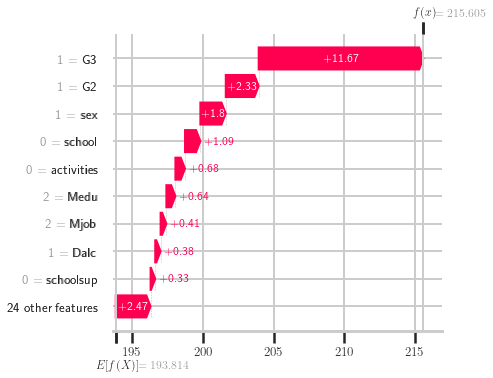

In [127]:
shap.plots.waterfall(shap_values[0], show=False)
f = plt.gcf()
# f.set_tight_layout(True)
plt.tight_layout()
f.savefig(r"student_shap_globalbounds_avg.png")

In [ ]:
s = average_shapley_values_of_group(ranked_data[:k], groups_global_bounds[0], selected_attributes, shap_values, output_file)
print(s)



In [ ]:

shap_values.append(shap_values[0])


shap.plots.waterfall(s, show=False)
f = plt.gcf()
# f.set_tight_layout(True)
plt.tight_layout()
f.savefig(r"student_shap_globalbounds.png")

True
[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


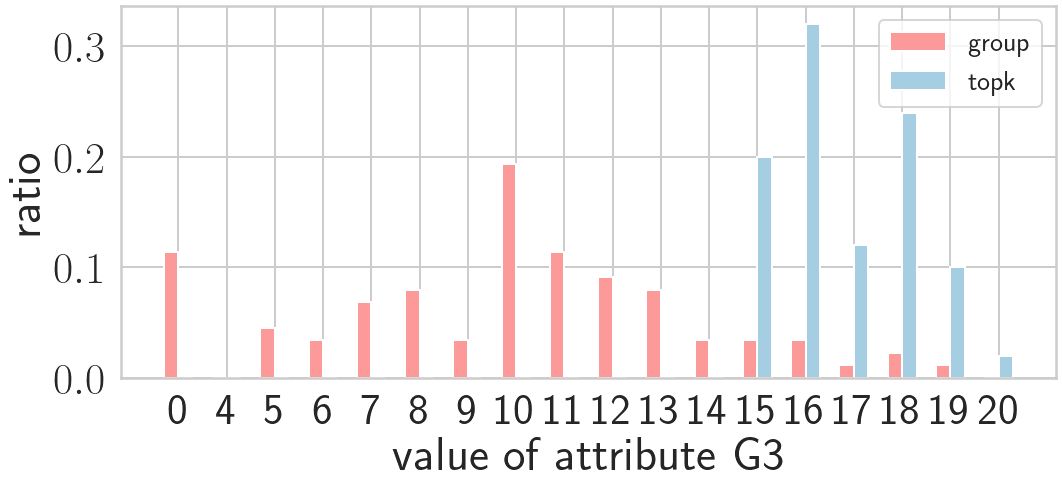

In [89]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc, Lowerbounds, k))

att = 'G3'
plt = plot_distribution_ratio(ranked_data, att, groups_global_bounds[1], another_group, k)
plt.savefig(r"student_value_dis_globalbounds.png")


True
['GP' 'MS']


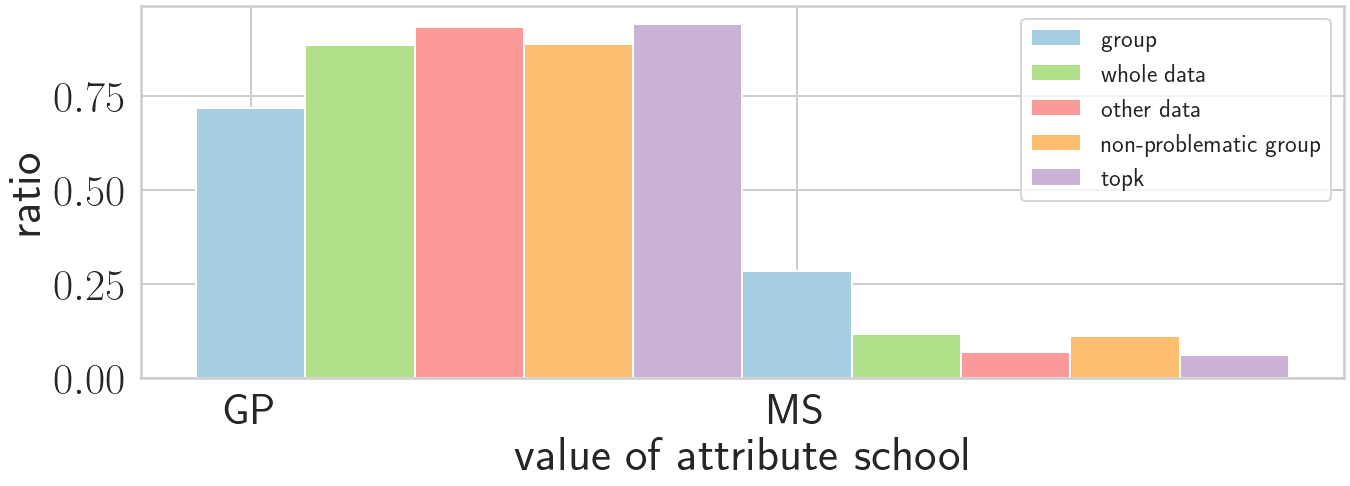

['F' 'M']


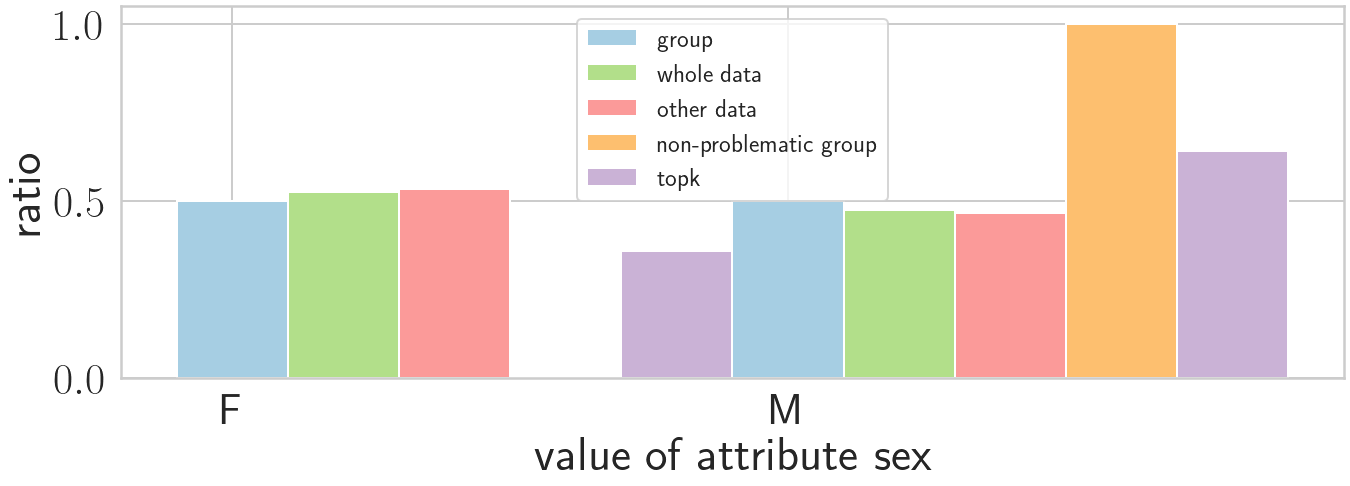

[15 16 17 18 19 20 21 22]


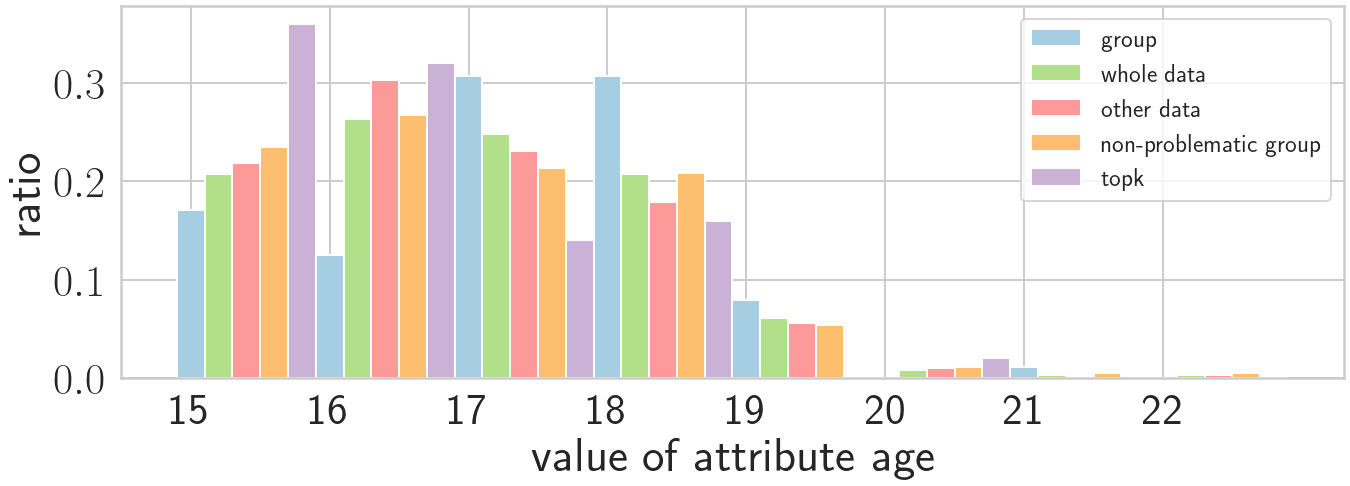

['R' 'U']


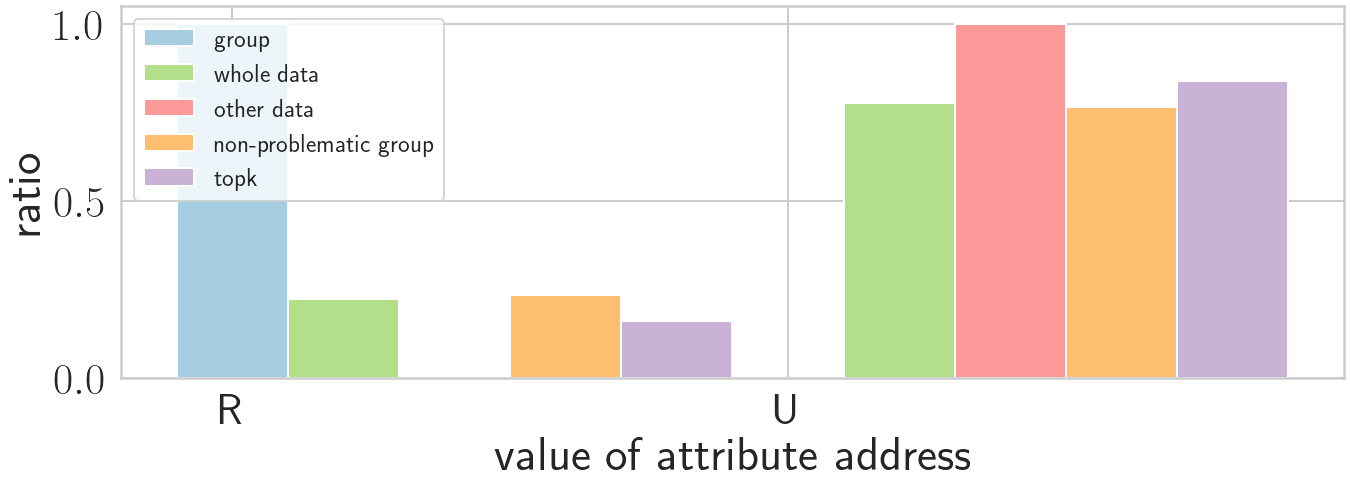

['GT3' 'LE3']


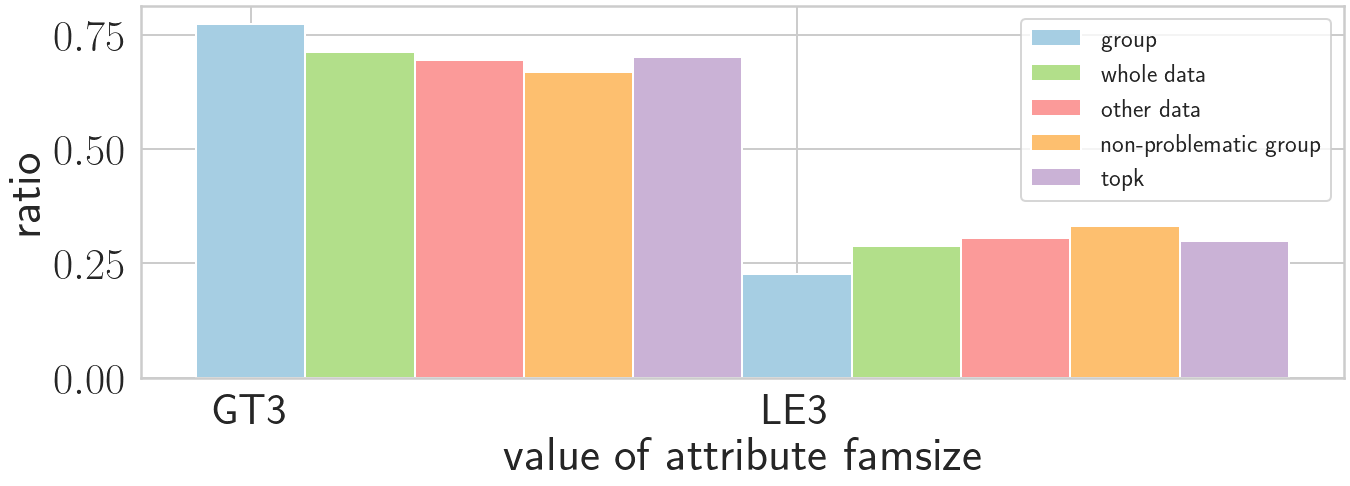

['A' 'T']


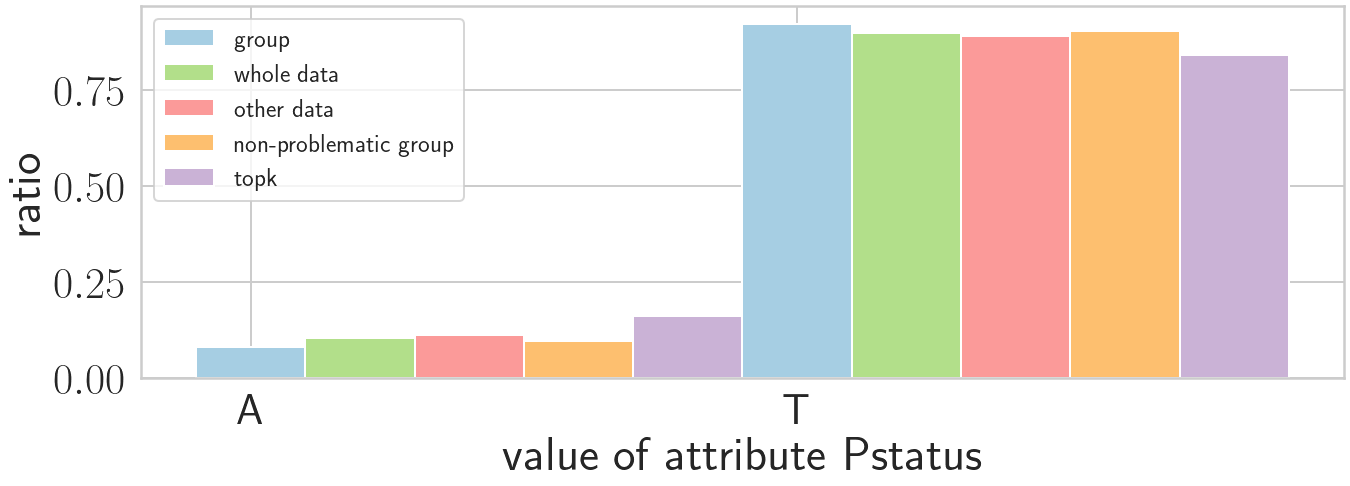

[0 1 2 3 4]


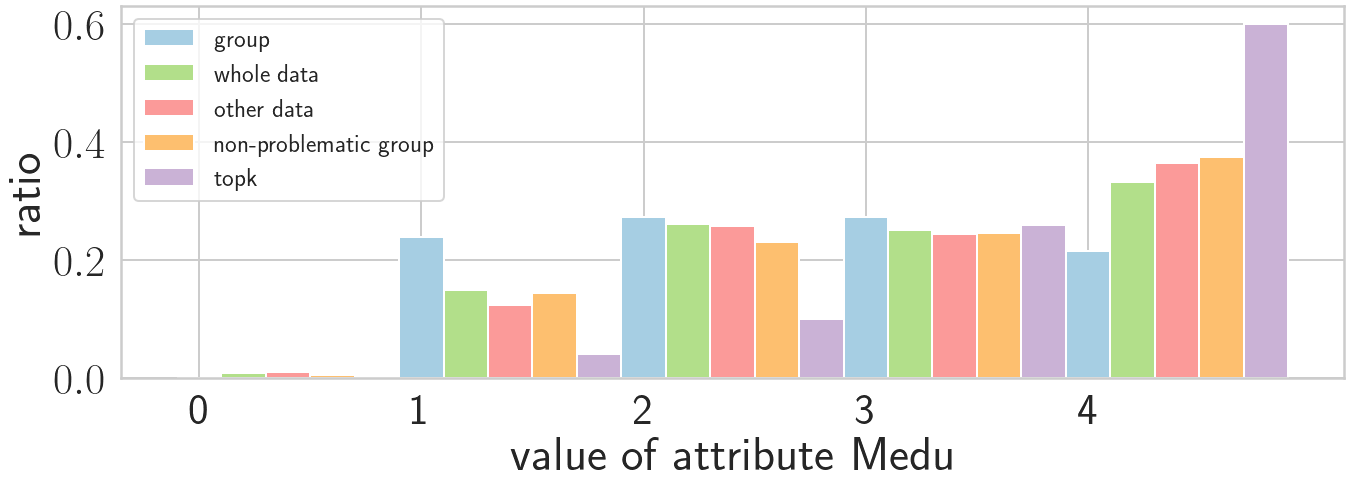

[0 1 2 3 4]


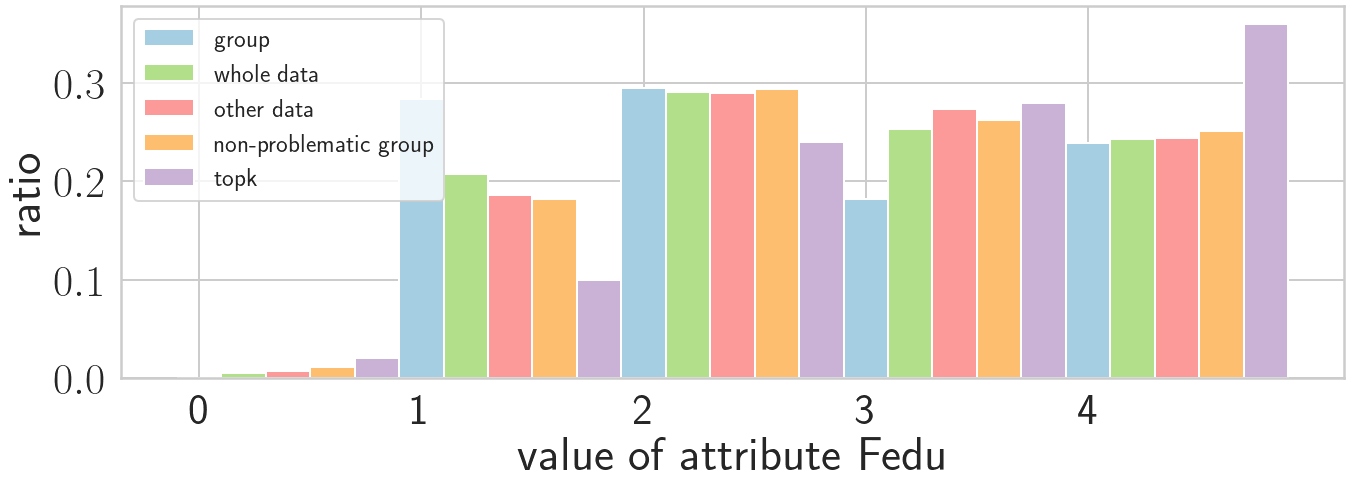

['at_home' 'health' 'other' 'services' 'teacher']


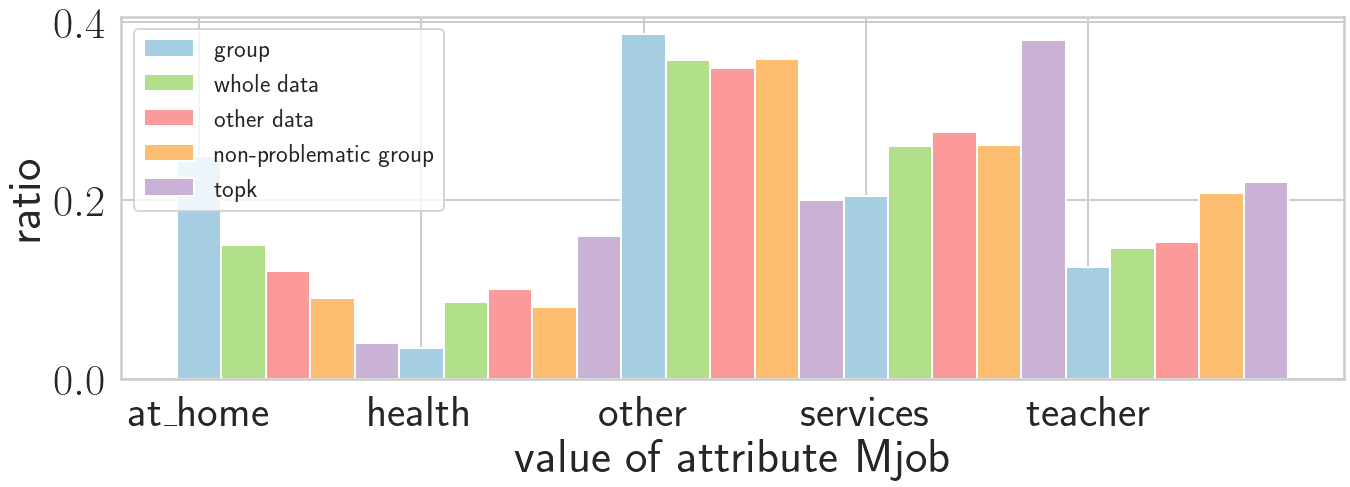

['at_home' 'health' 'other' 'services' 'teacher']


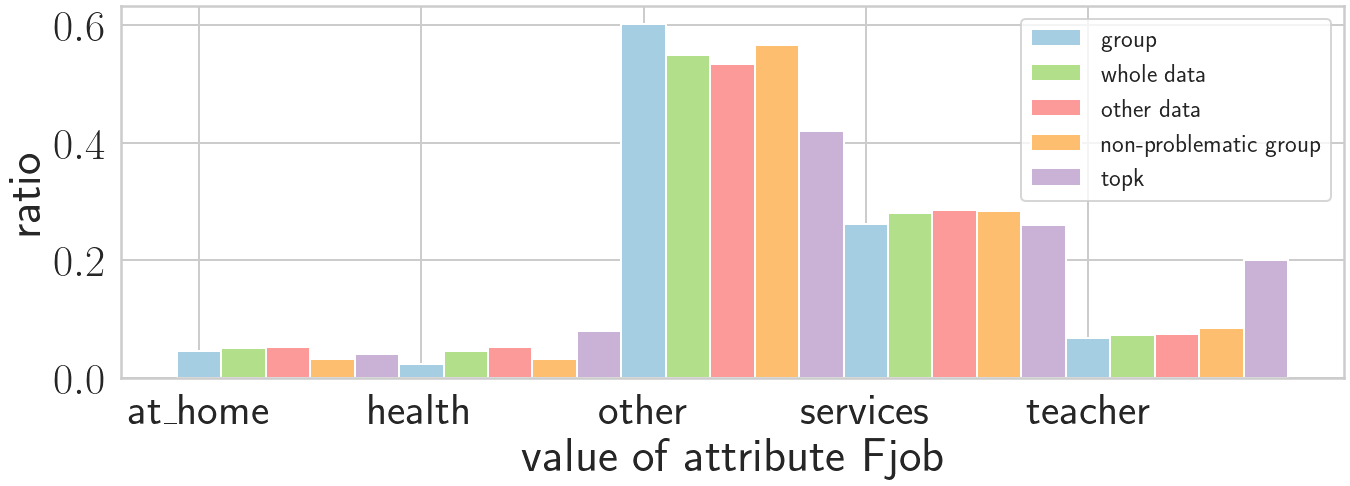

['course' 'home' 'other' 'reputation']


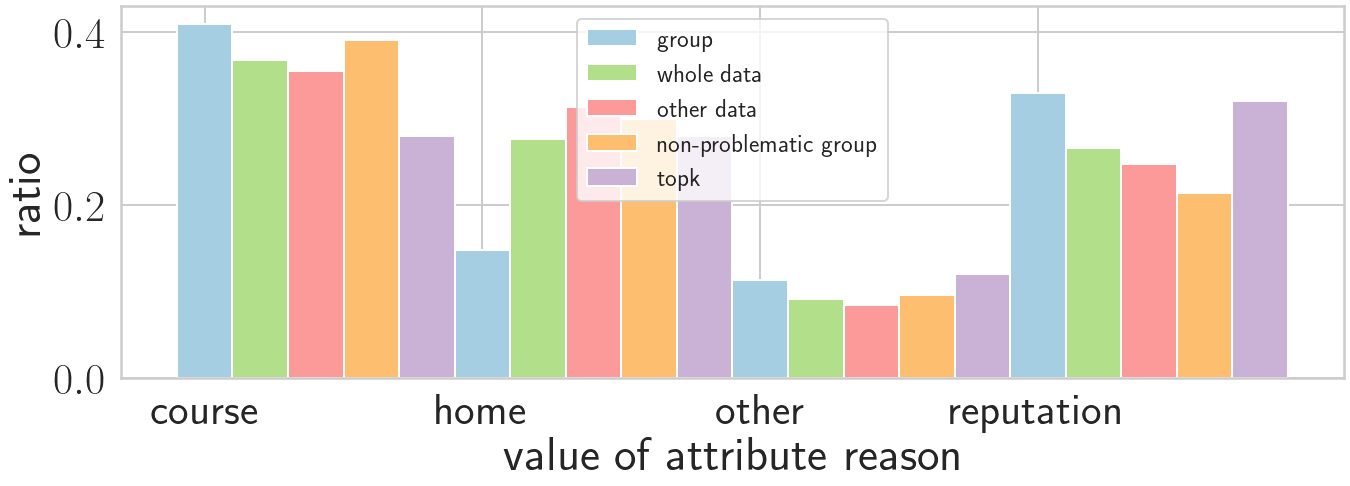

['father' 'mother' 'other']


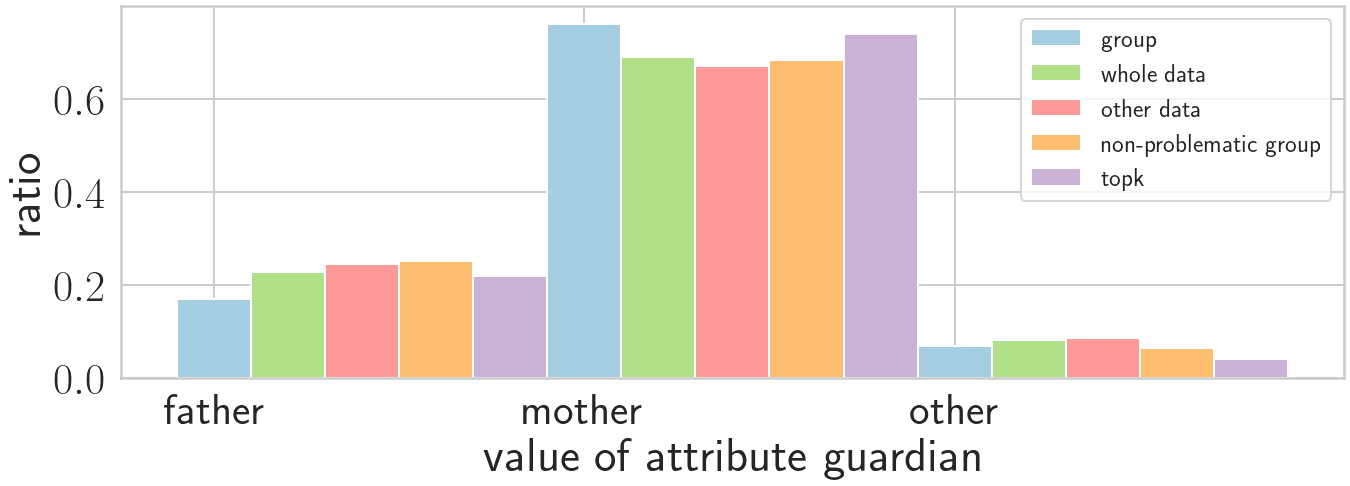

[1 2 3 4]


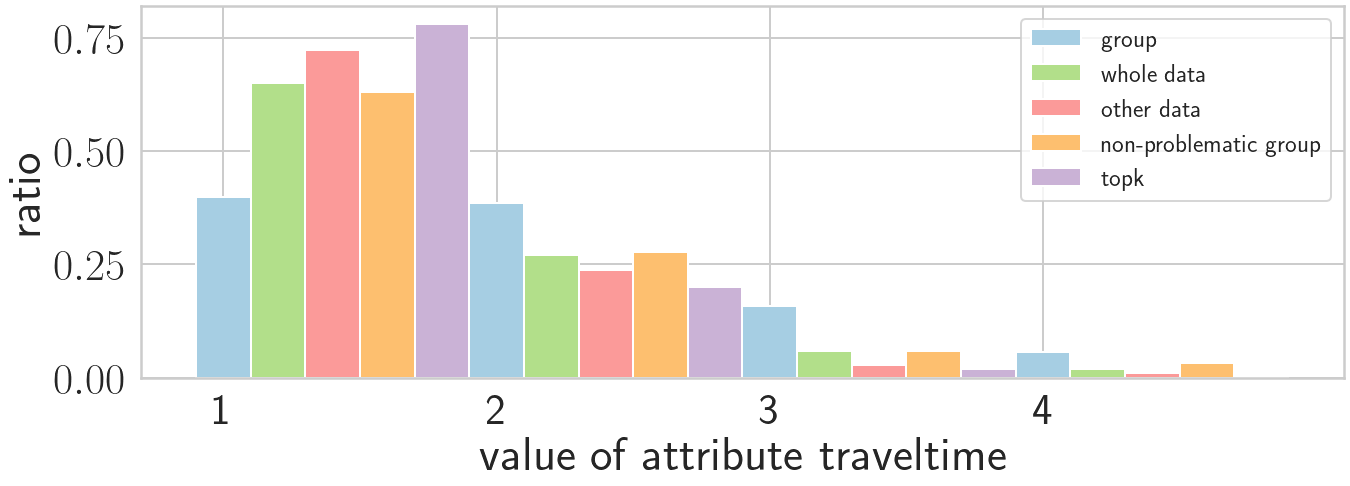

[1 2 3 4]


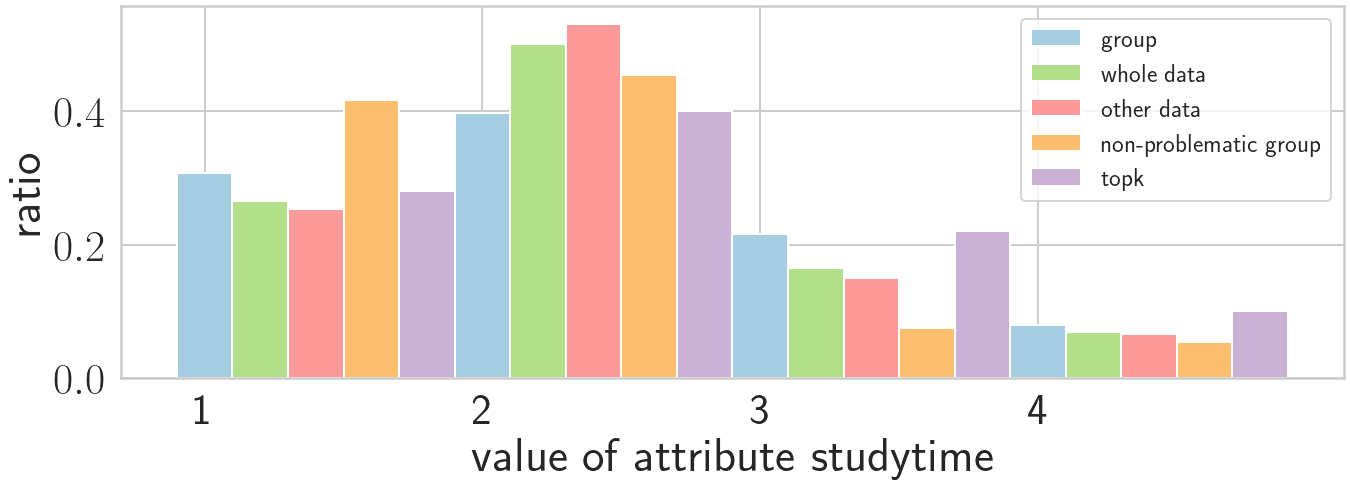

[0 1 2 3]


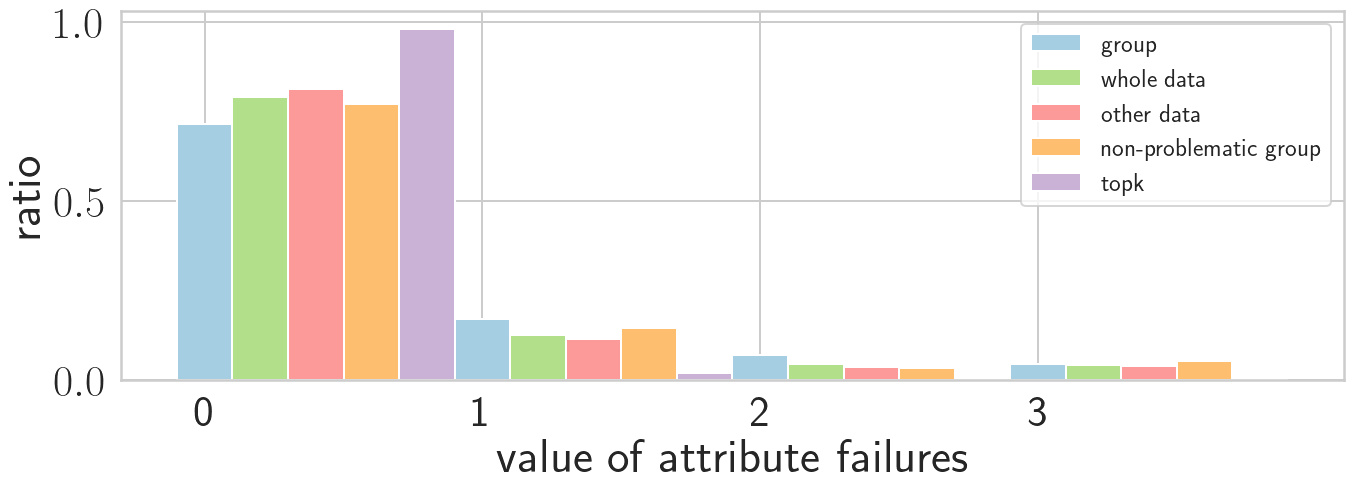

['no' 'yes']


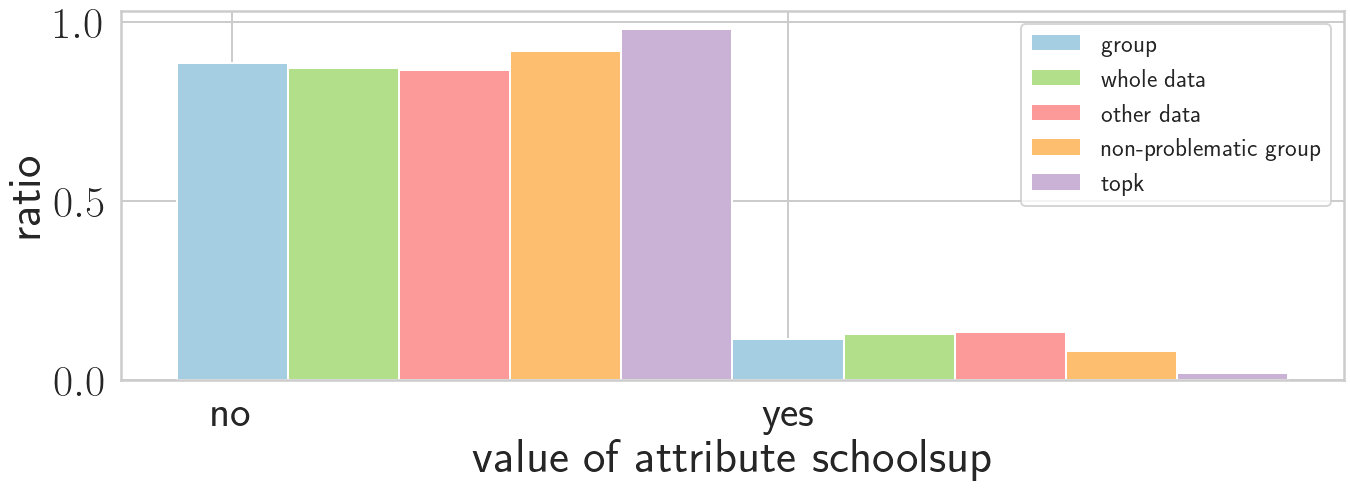

['no' 'yes']


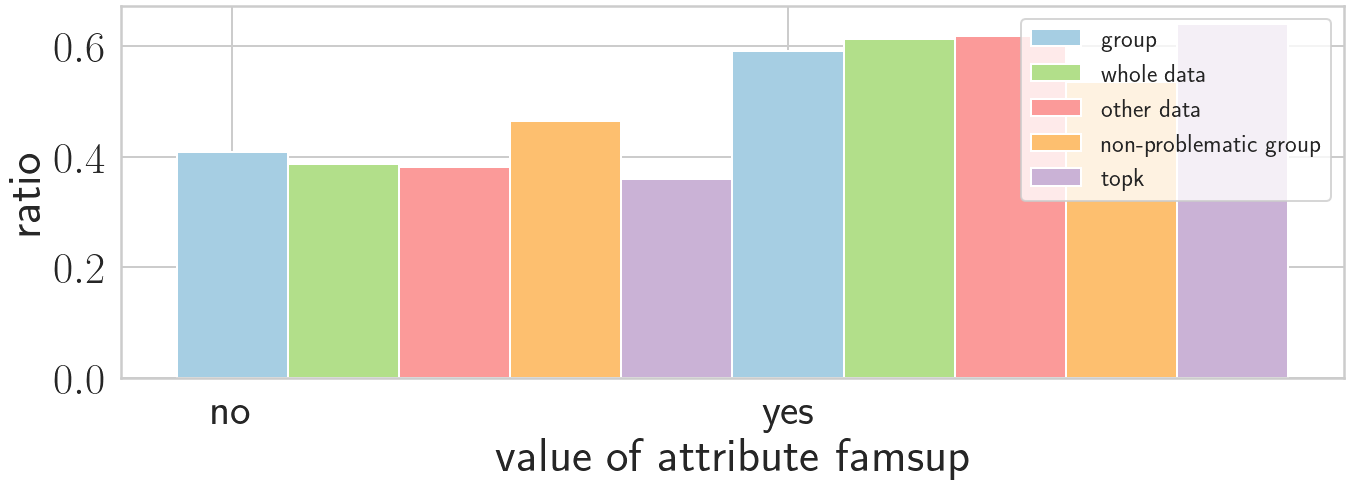

['no' 'yes']


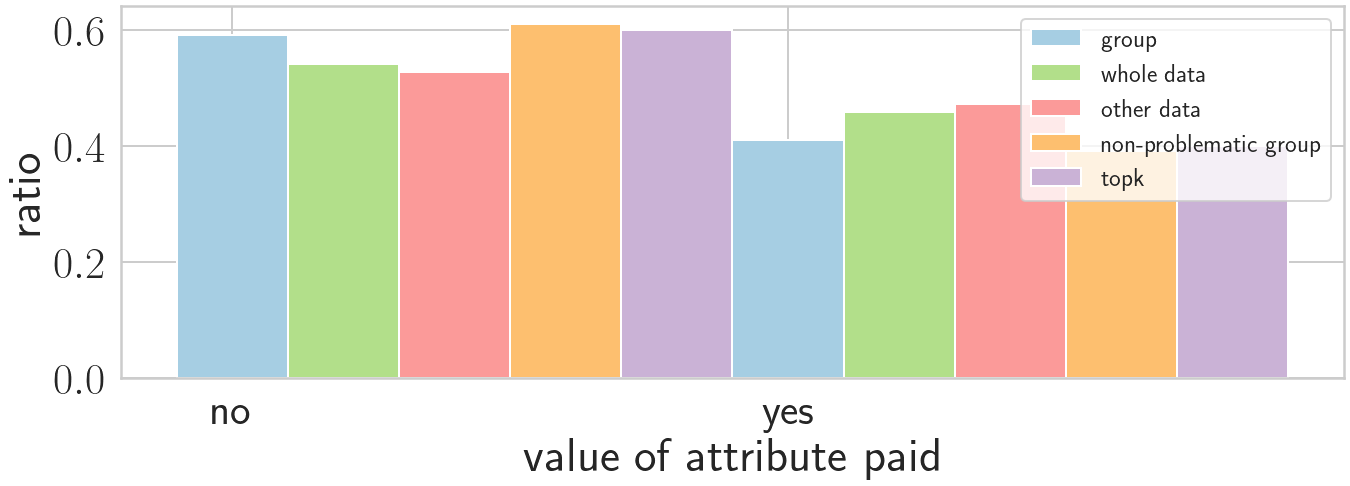

['no' 'yes']


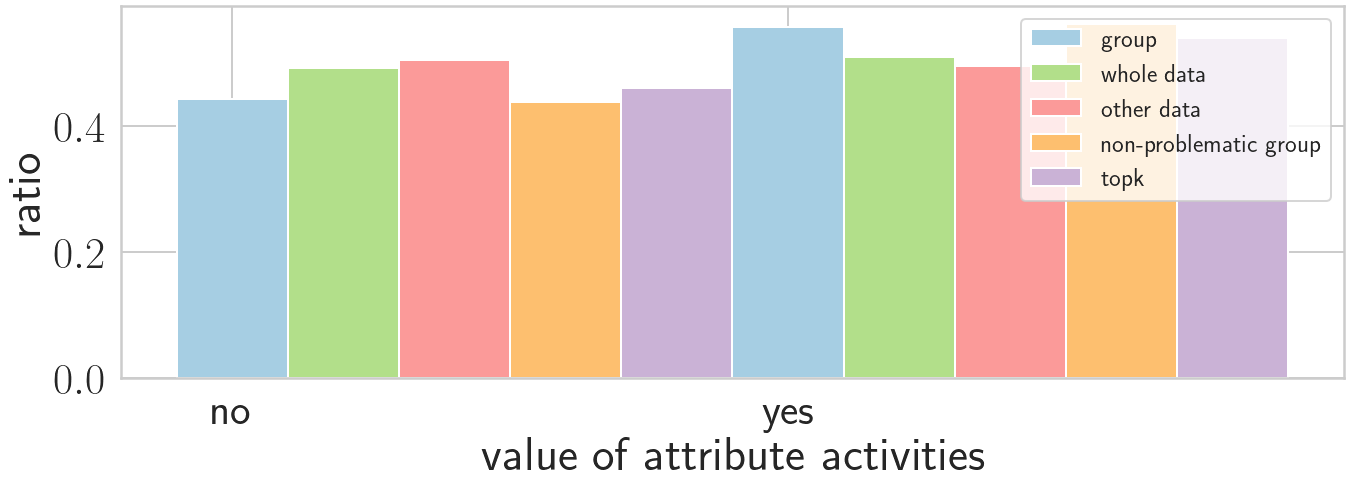

['no' 'yes']


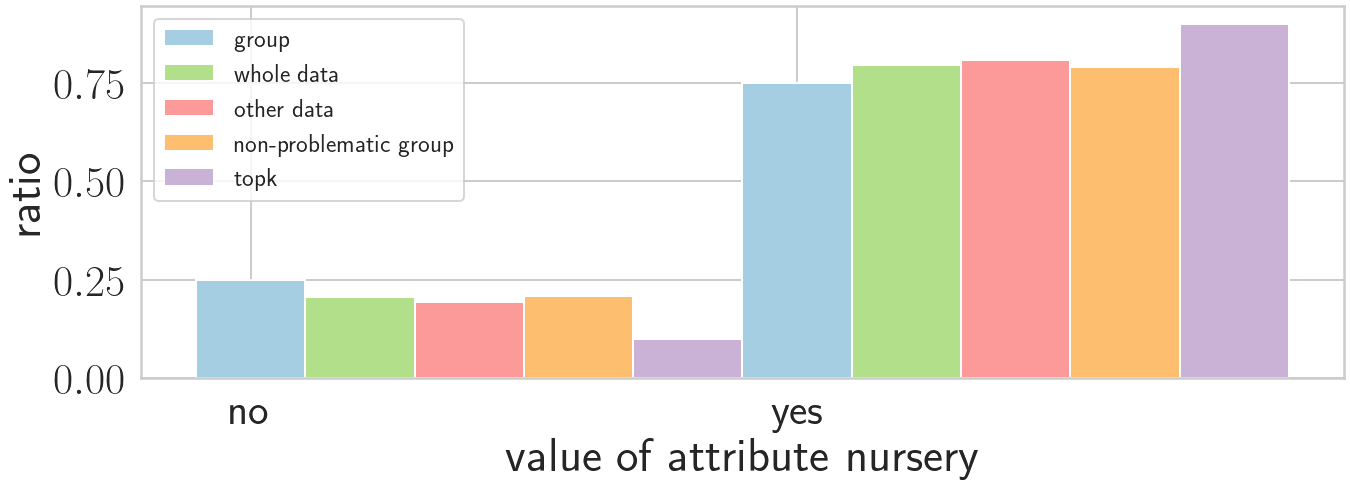

['no' 'yes']


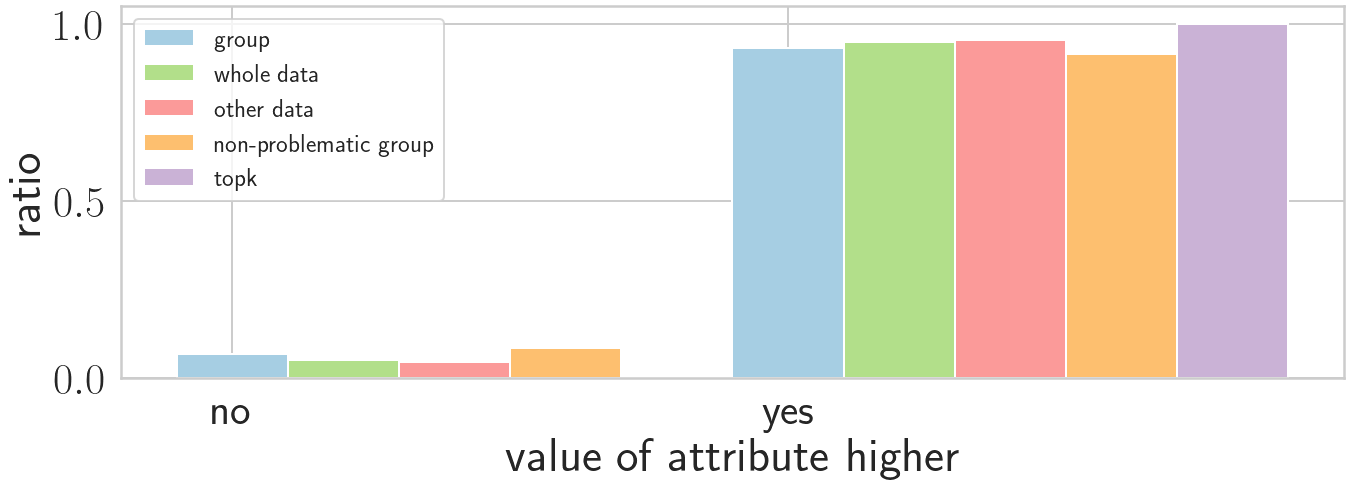

['no' 'yes']


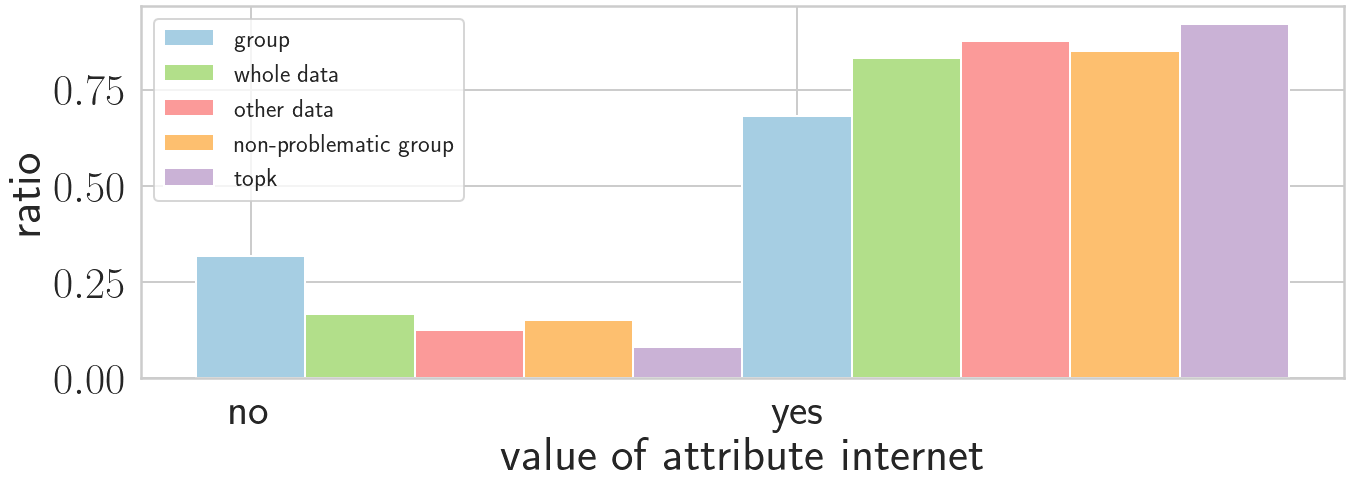

['no' 'yes']


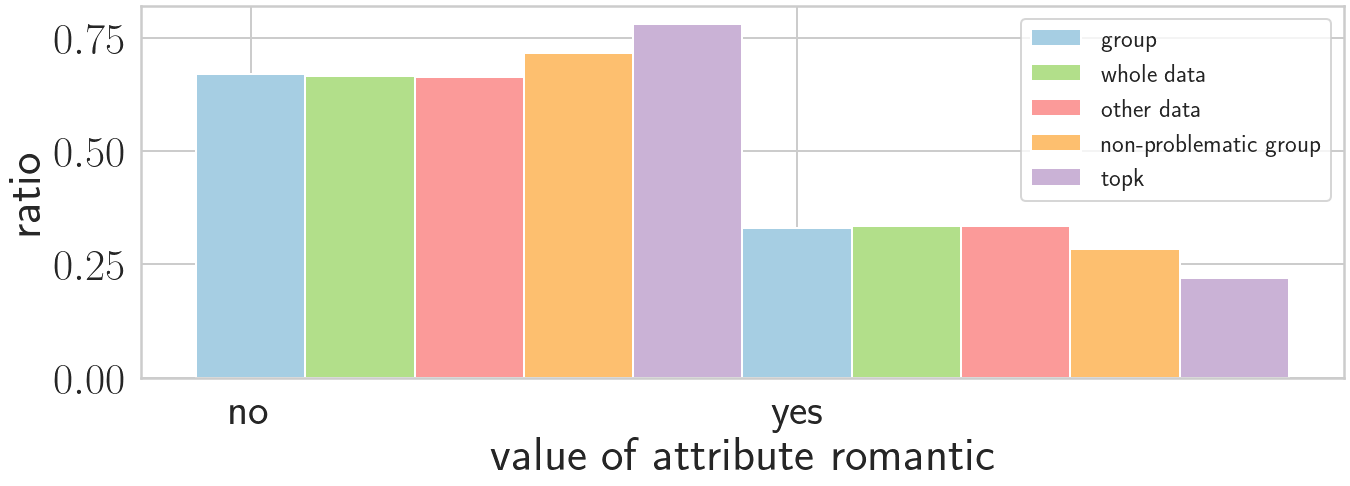

[1 2 3 4 5]


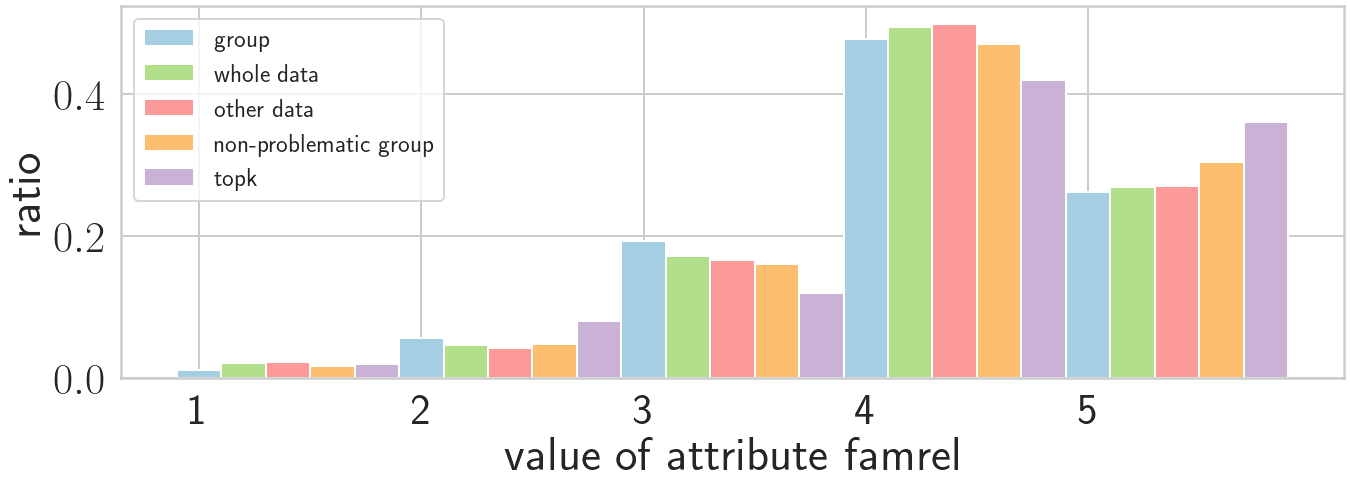

[1 2 3 4 5]


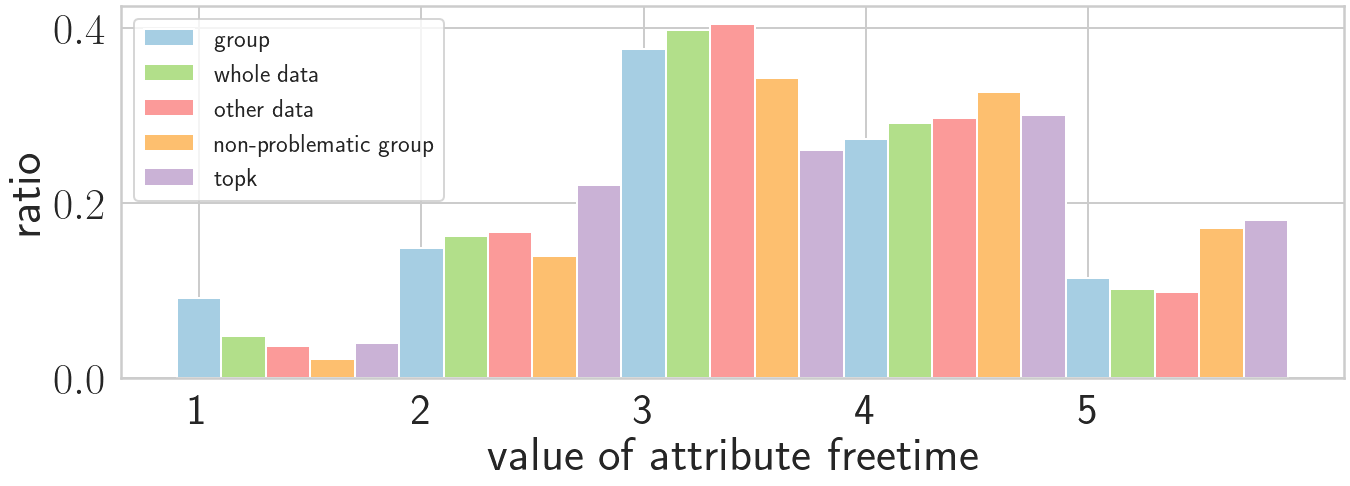

[1 2 3 4 5]


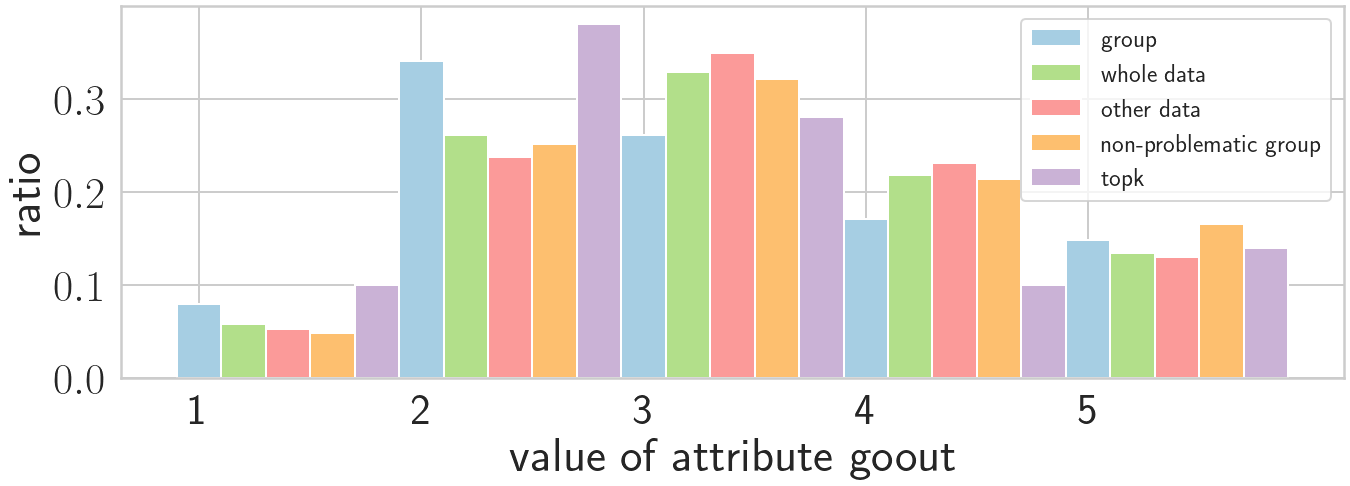

[1 2 3 4 5]


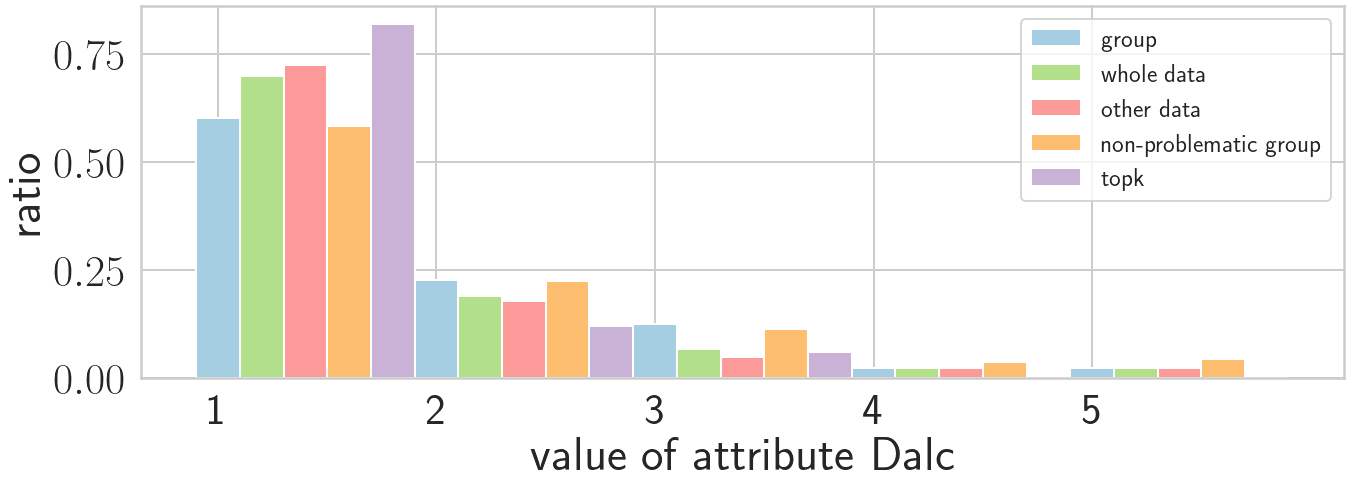

[1 2 3 4 5]


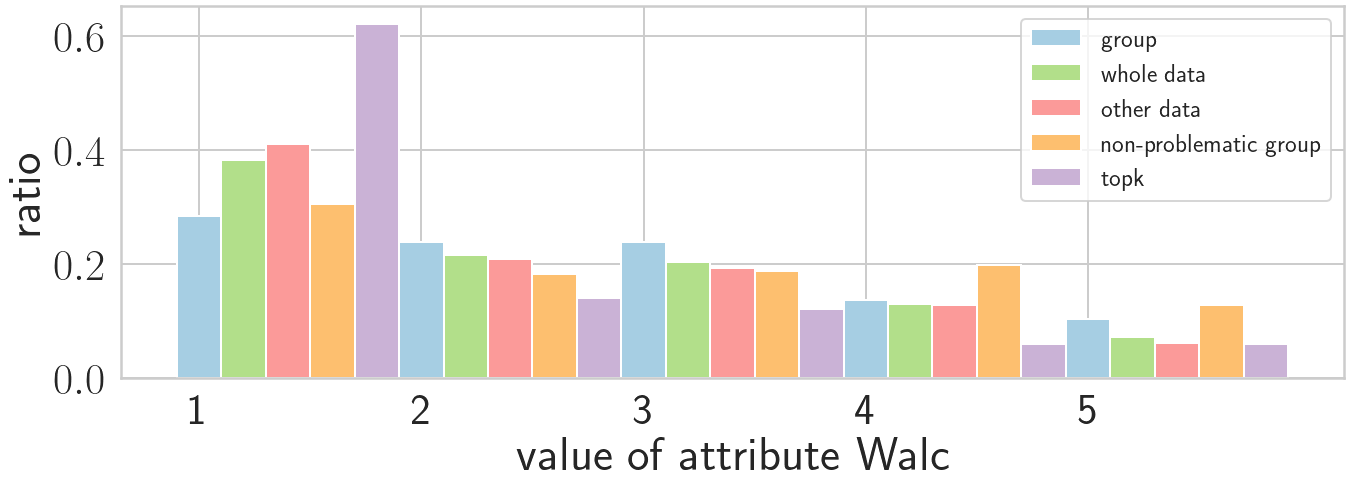

[1 2 3 4 5]


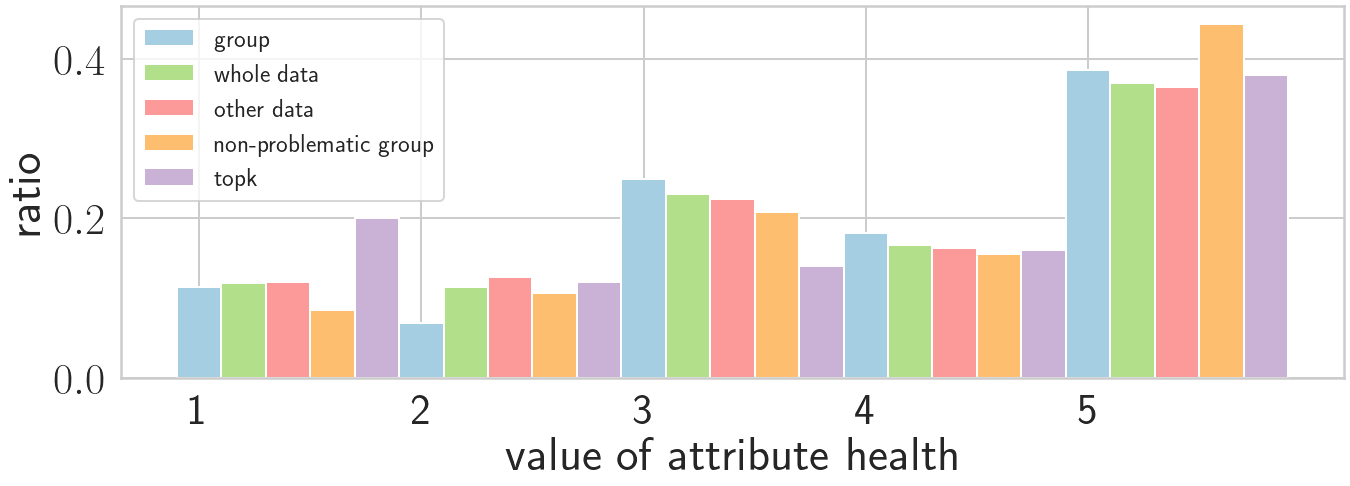

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 30 38 40 54 56 75]


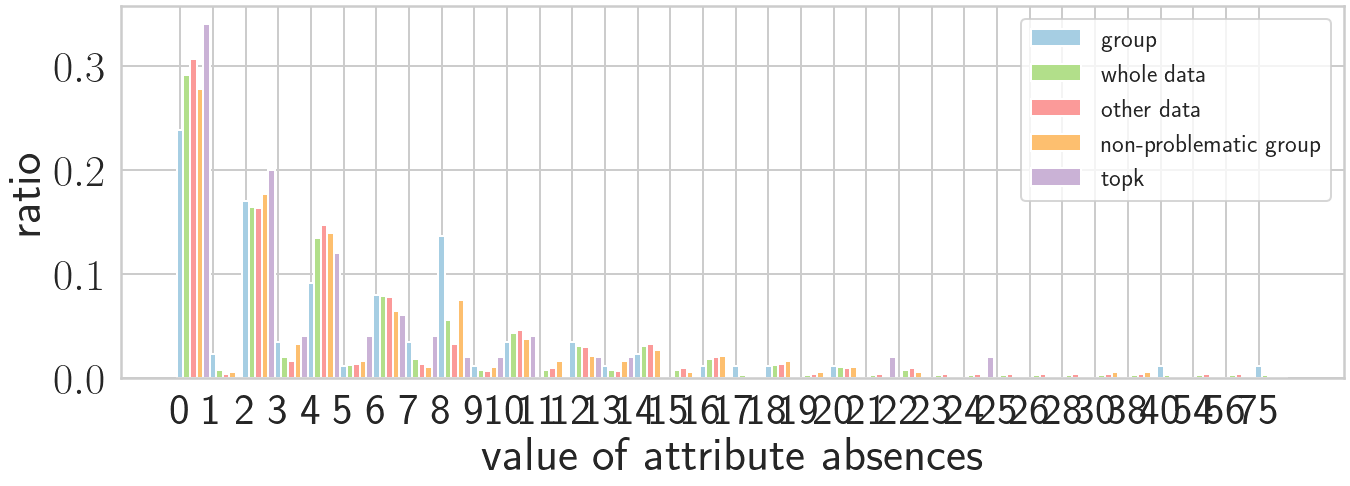

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


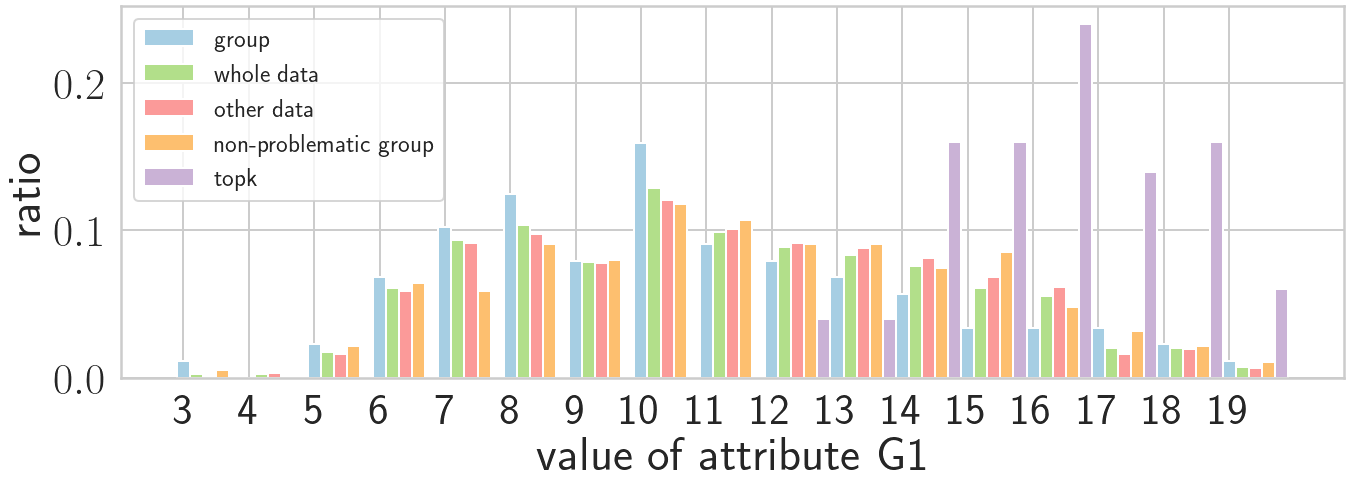

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


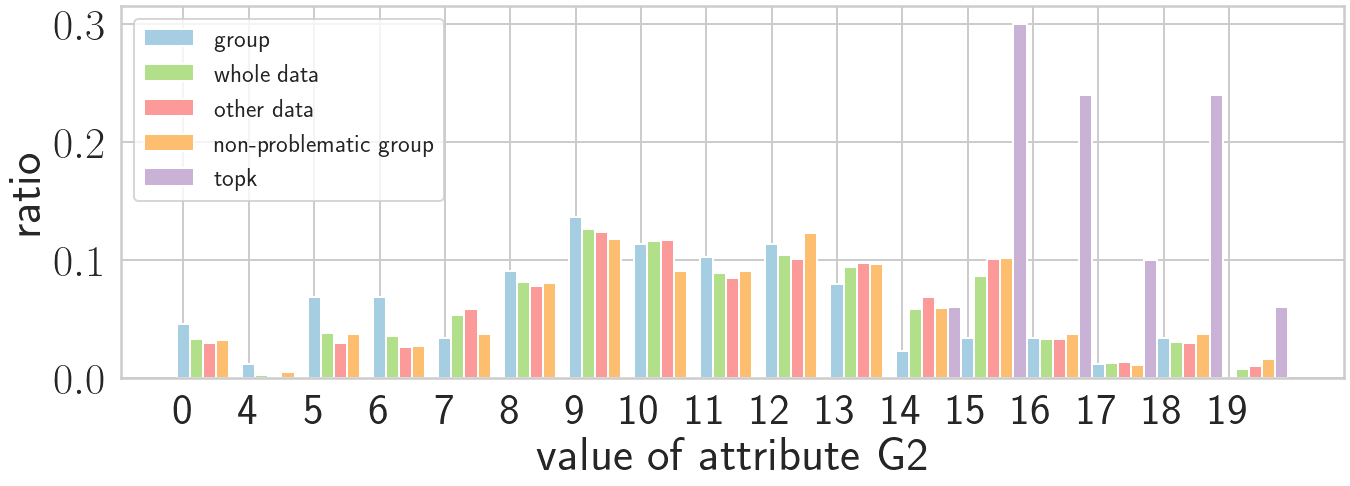

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


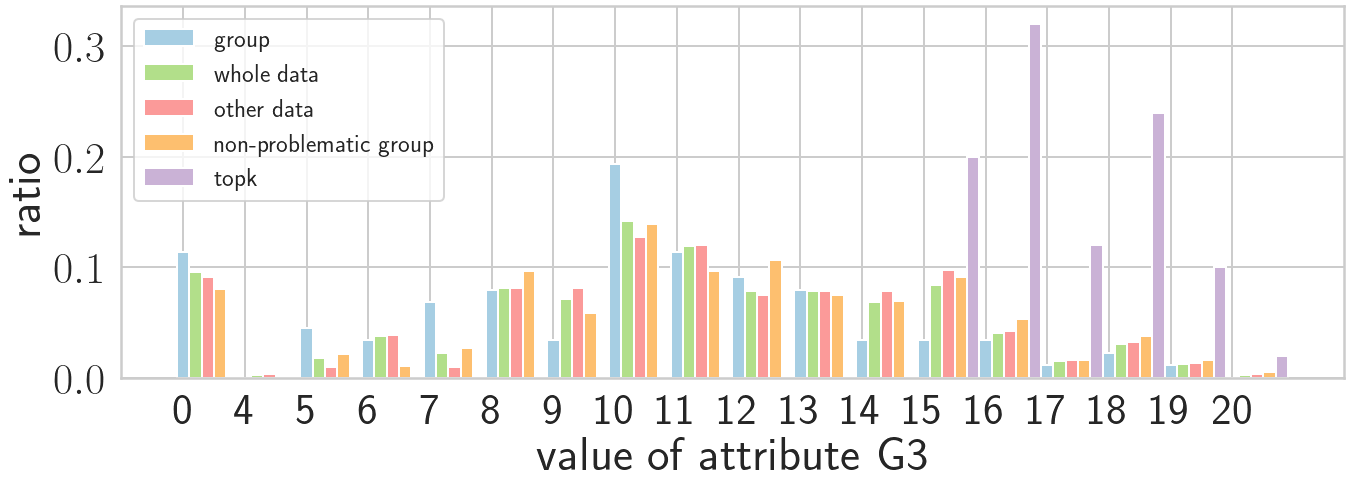

In [50]:
another_group = [-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_global_bounds(another_group, ranked_data, selected_attributes, thc, Lowerbounds, k))
for att in all_attributes_original:
    plot_distribution_ratio(ranked_data, att, groups_global_bounds[1], another_group, k)


395 50 40.0
True
['GP' 'MS']


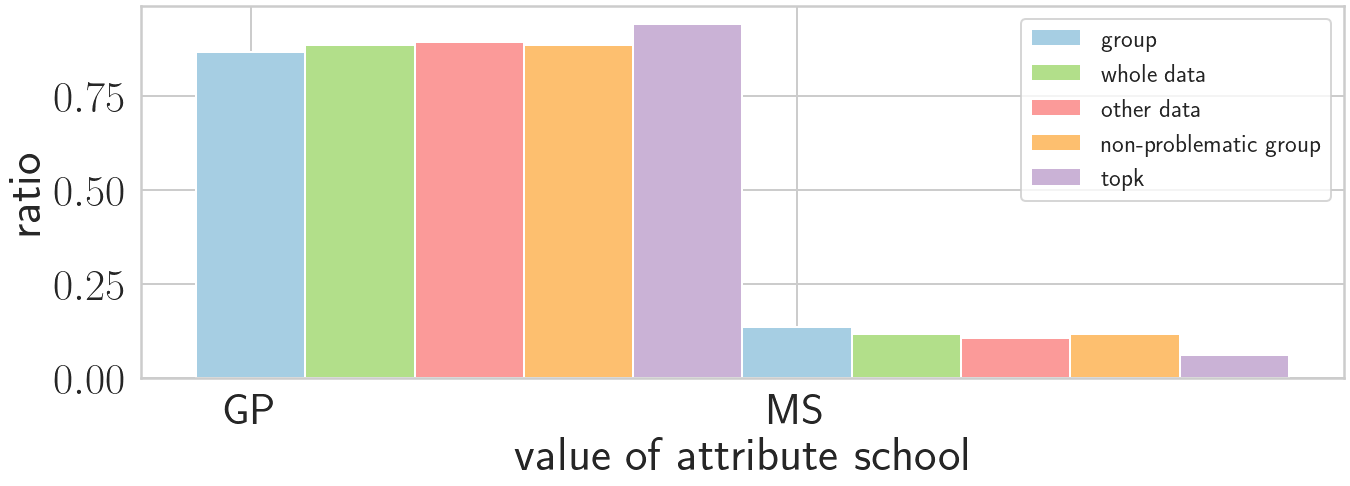

['F' 'M']


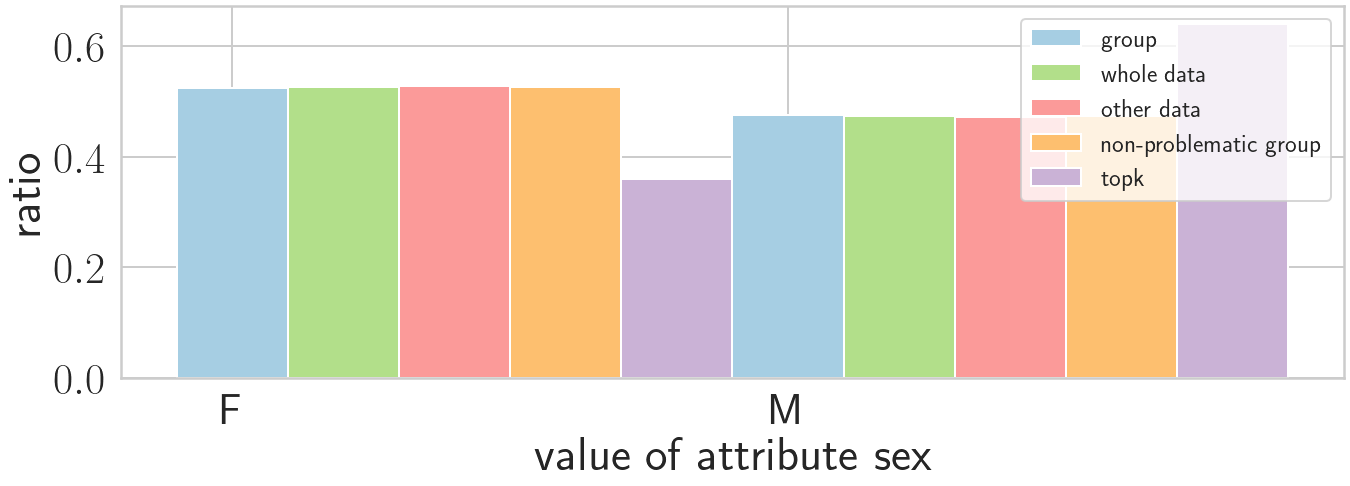

[15 16 17 18 19 20 21 22]


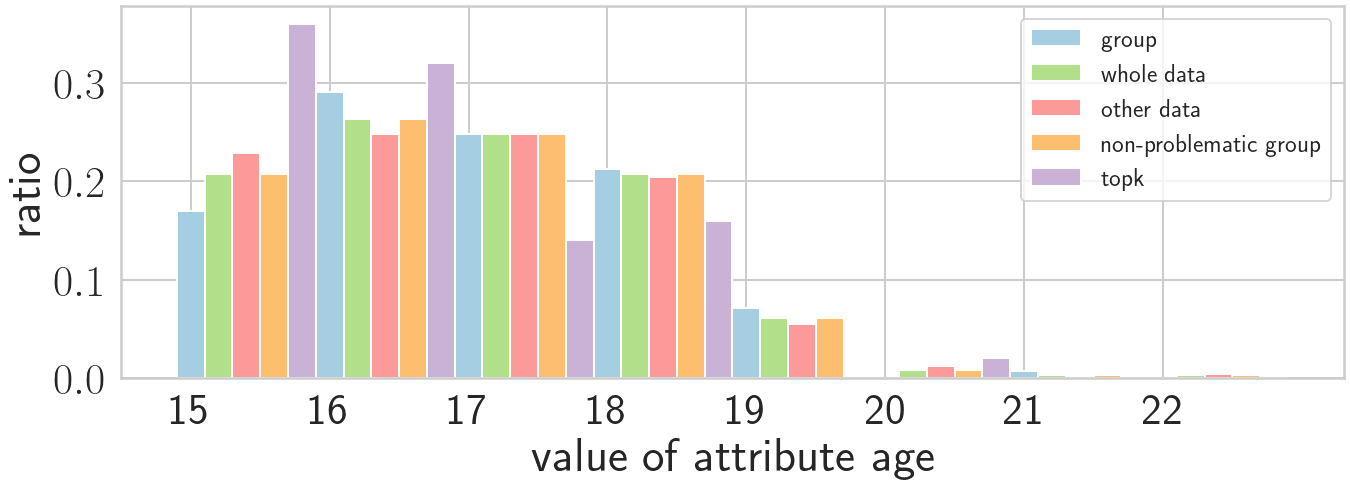

['R' 'U']


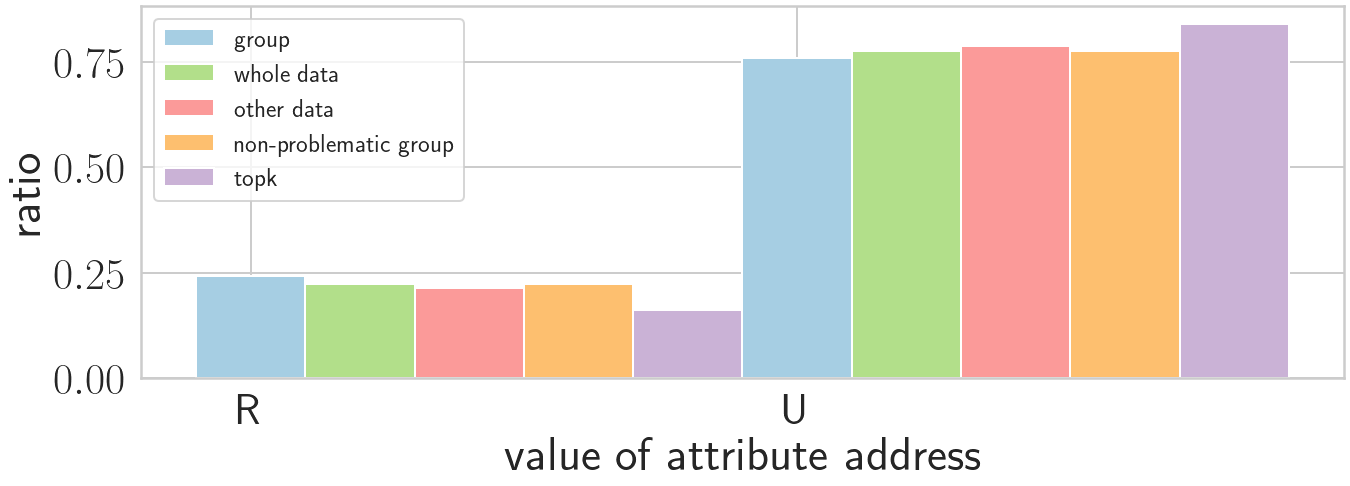

['GT3' 'LE3']


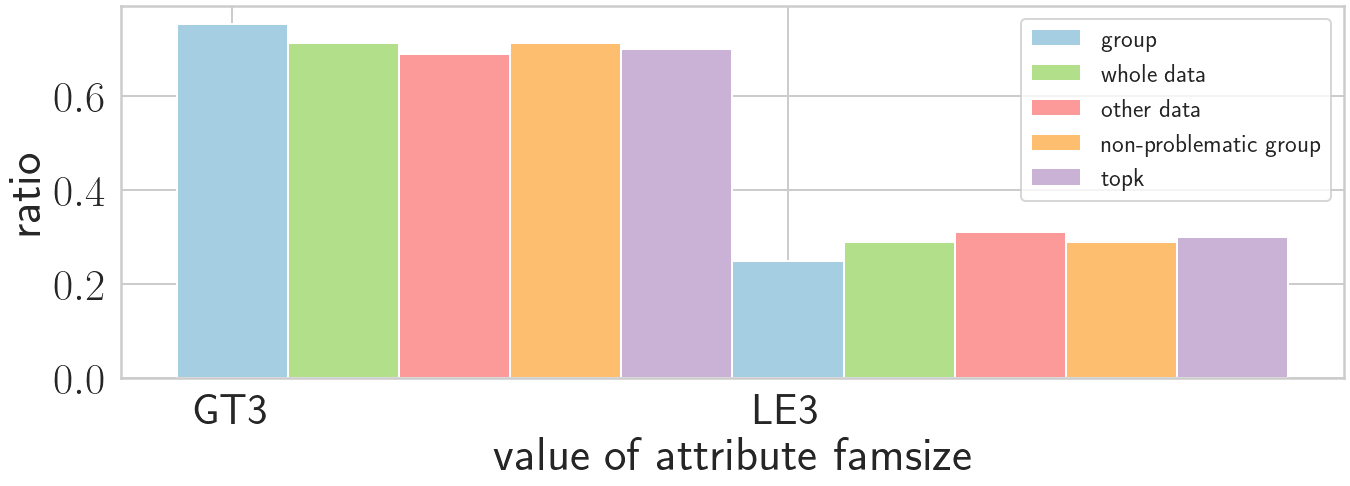

['A' 'T']


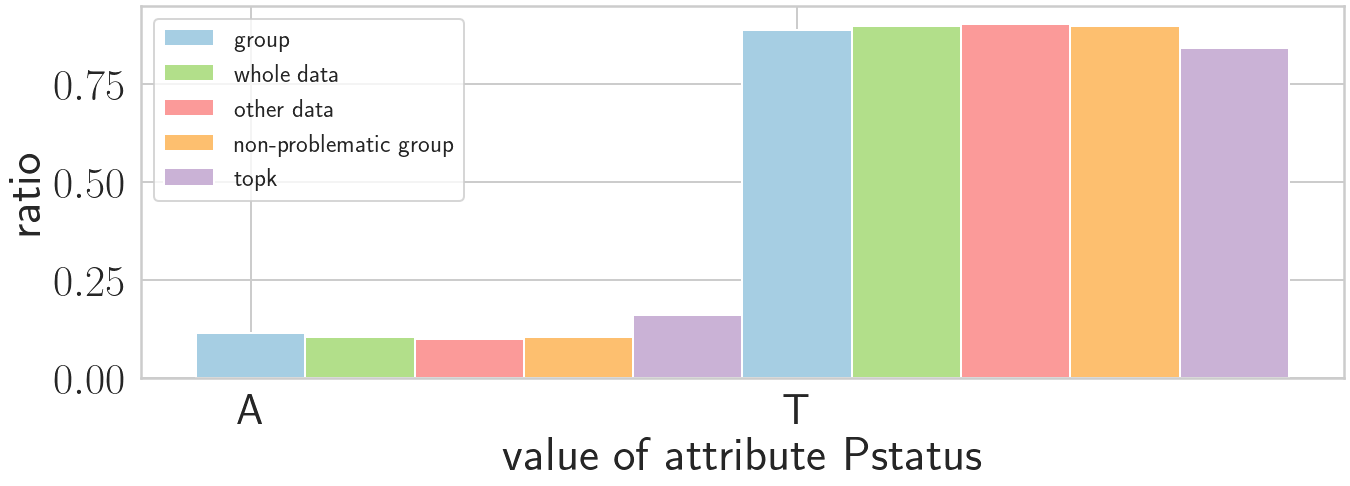

[0 1 2 3 4]


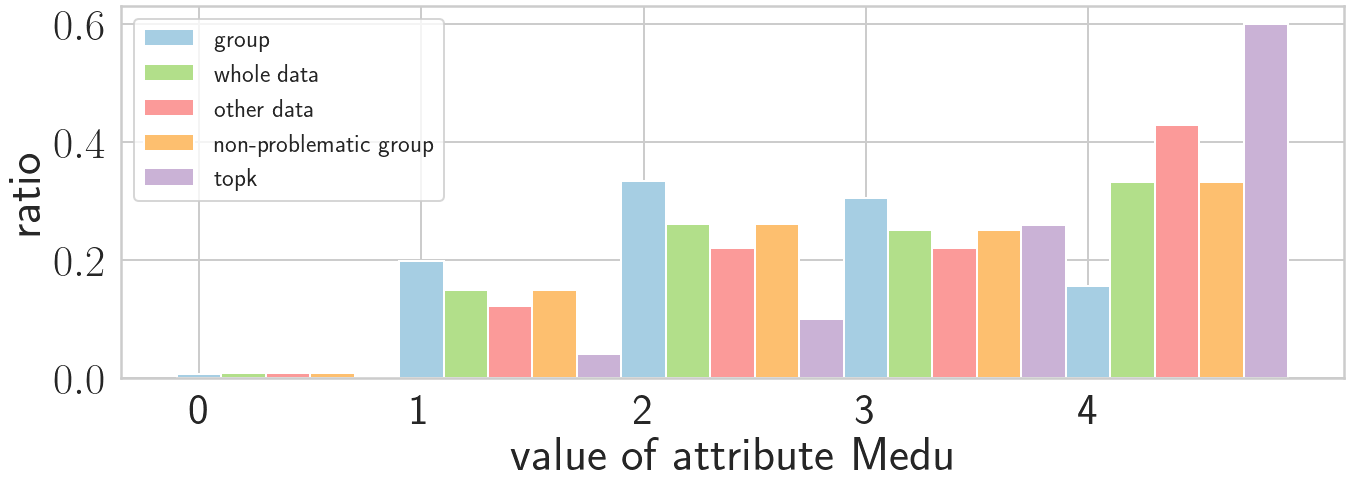

[0 1 2 3 4]


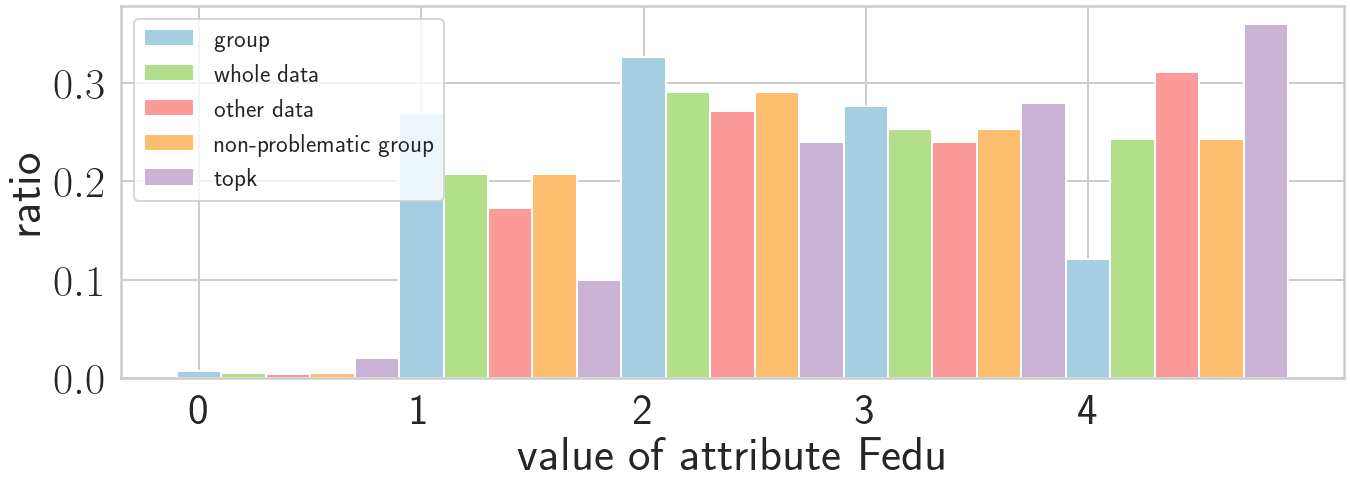

['at_home' 'health' 'other' 'services' 'teacher']


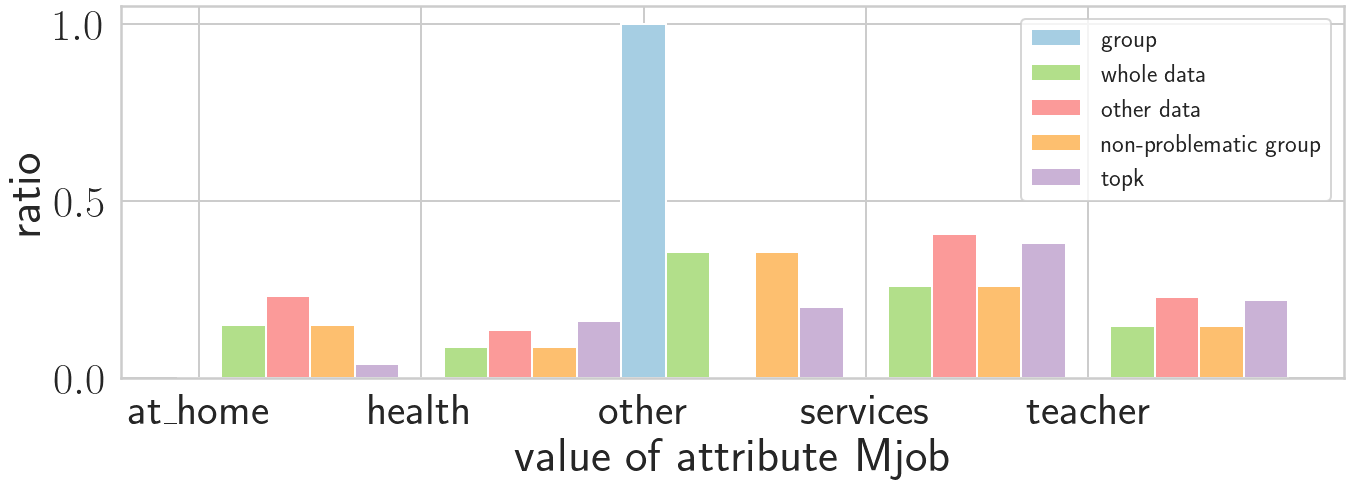

['at_home' 'health' 'other' 'services' 'teacher']


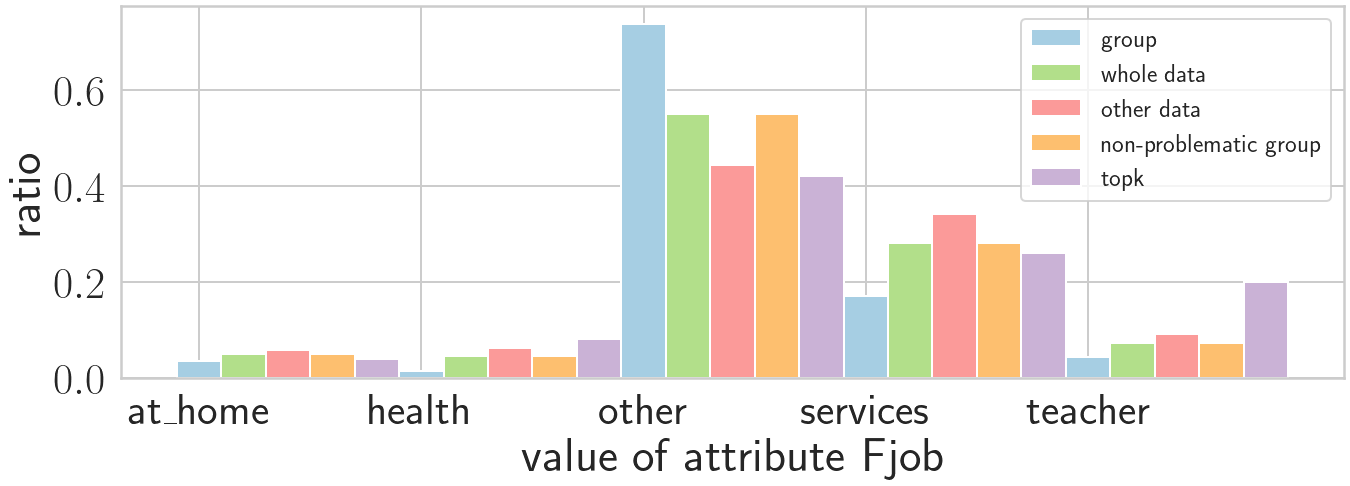

['course' 'home' 'other' 'reputation']


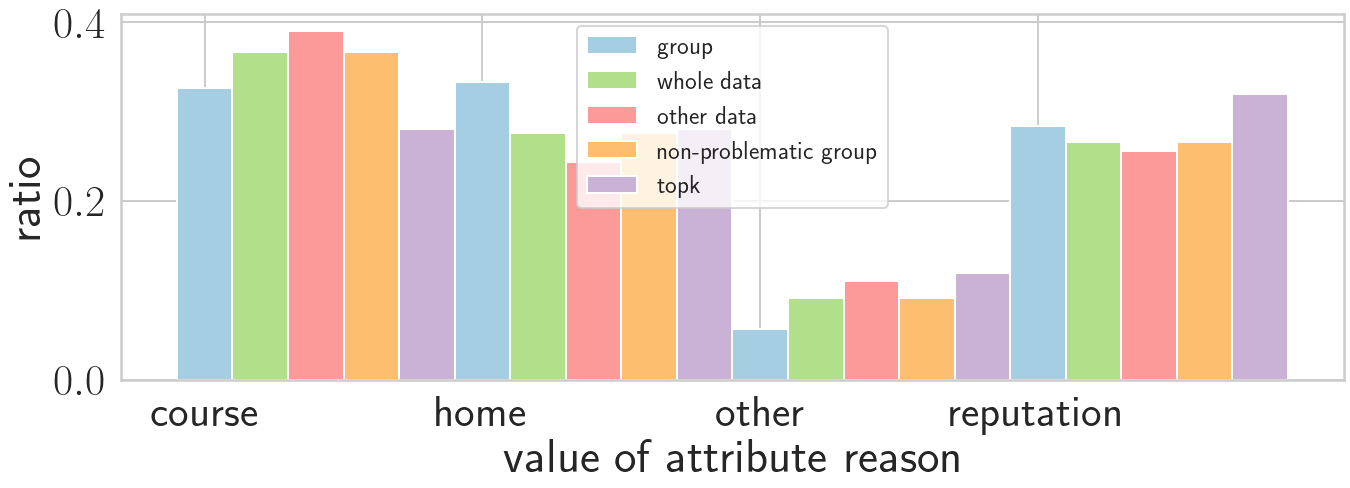

['father' 'mother' 'other']


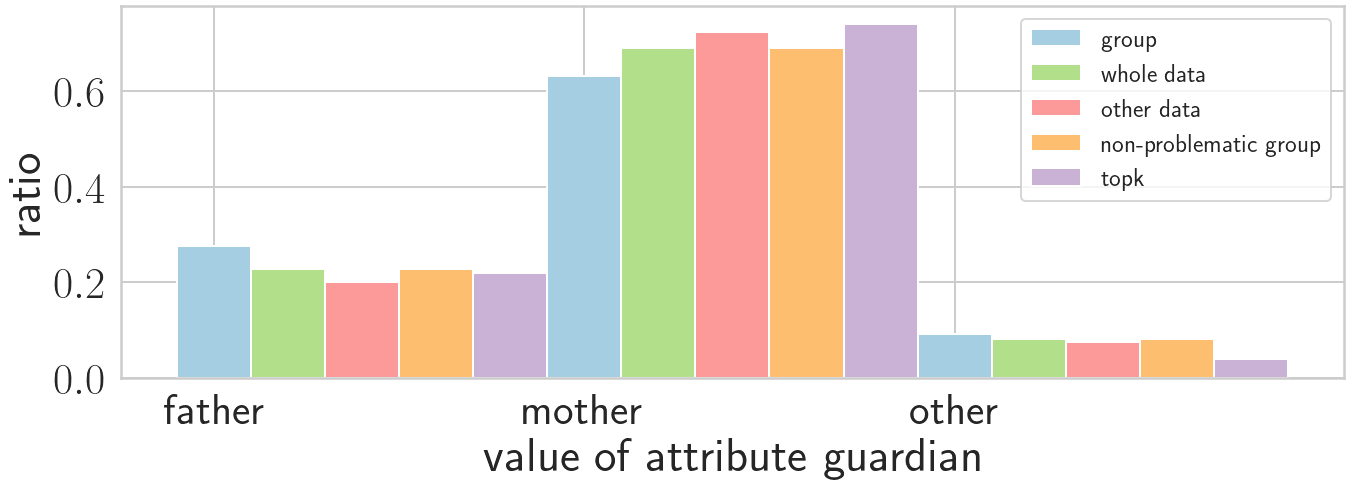

[1 2 3 4]


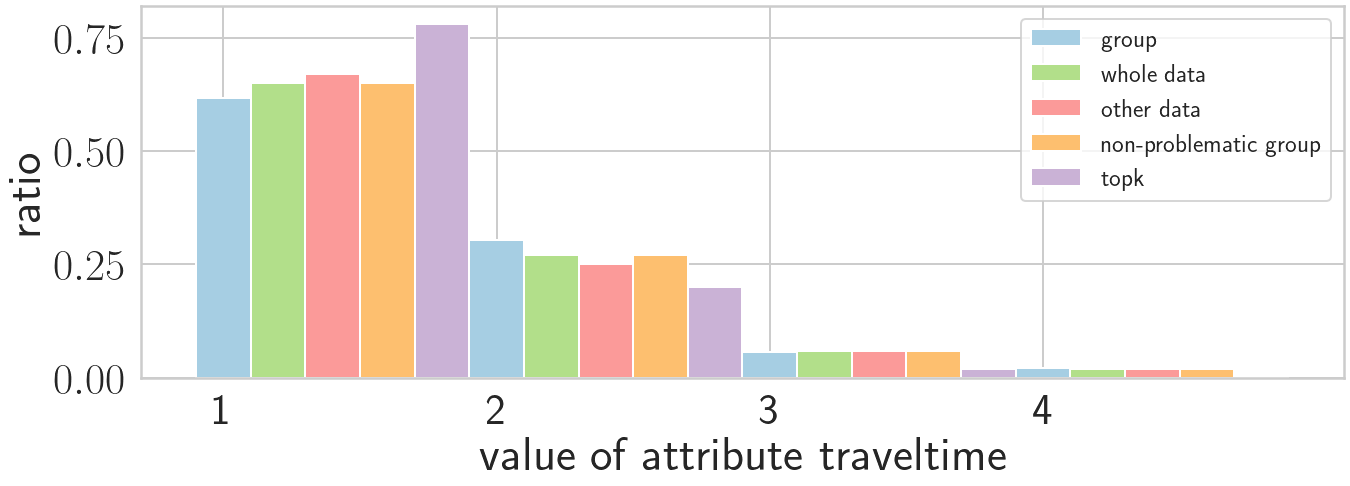

[1 2 3 4]


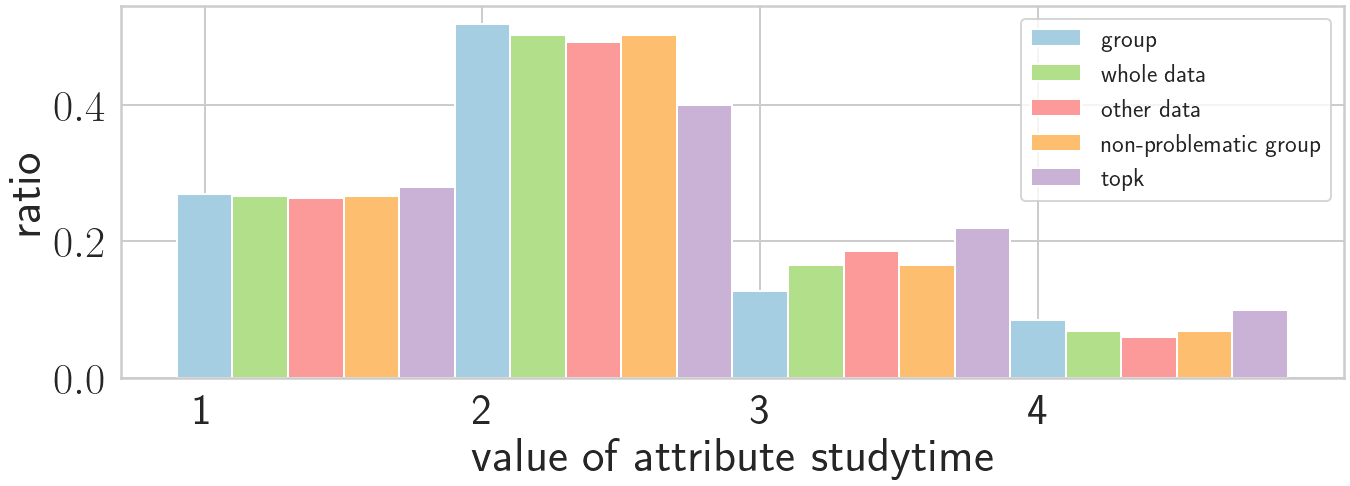

[0 1 2 3]


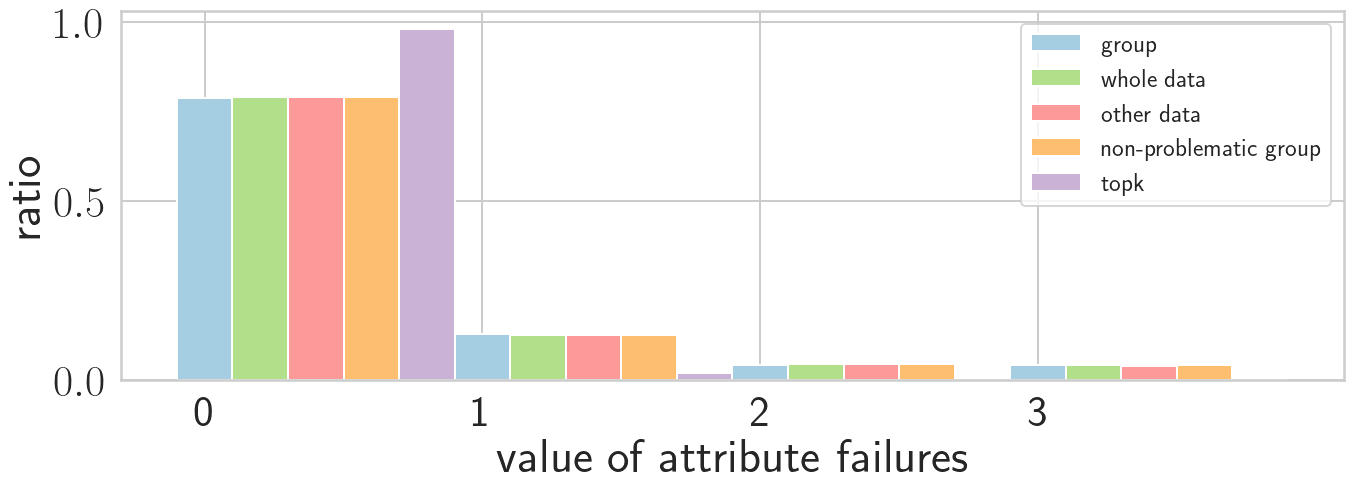

['no' 'yes']


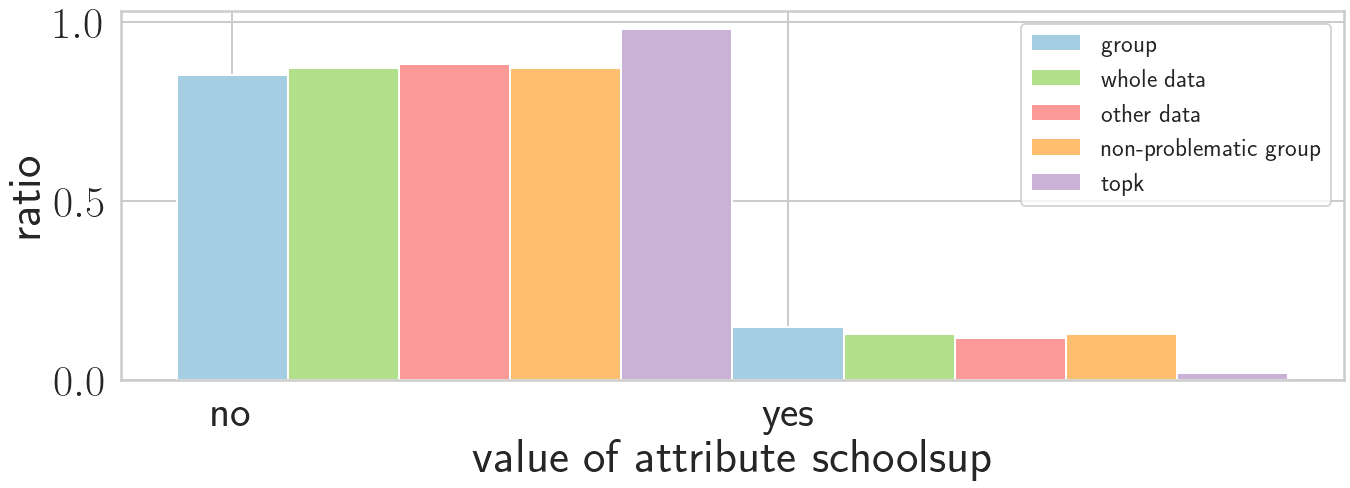

['no' 'yes']


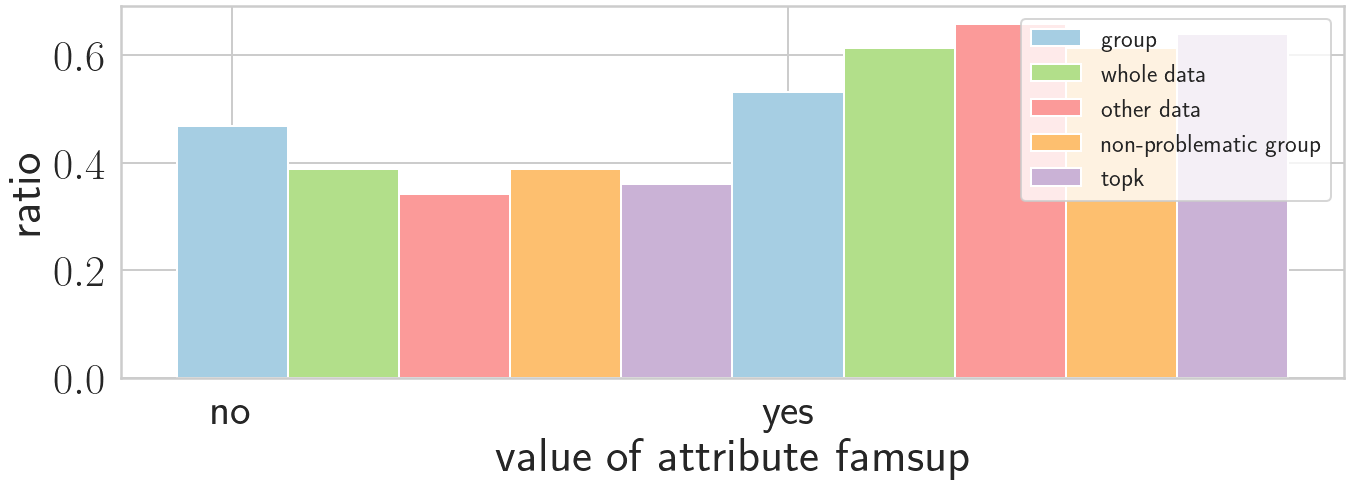

['no' 'yes']


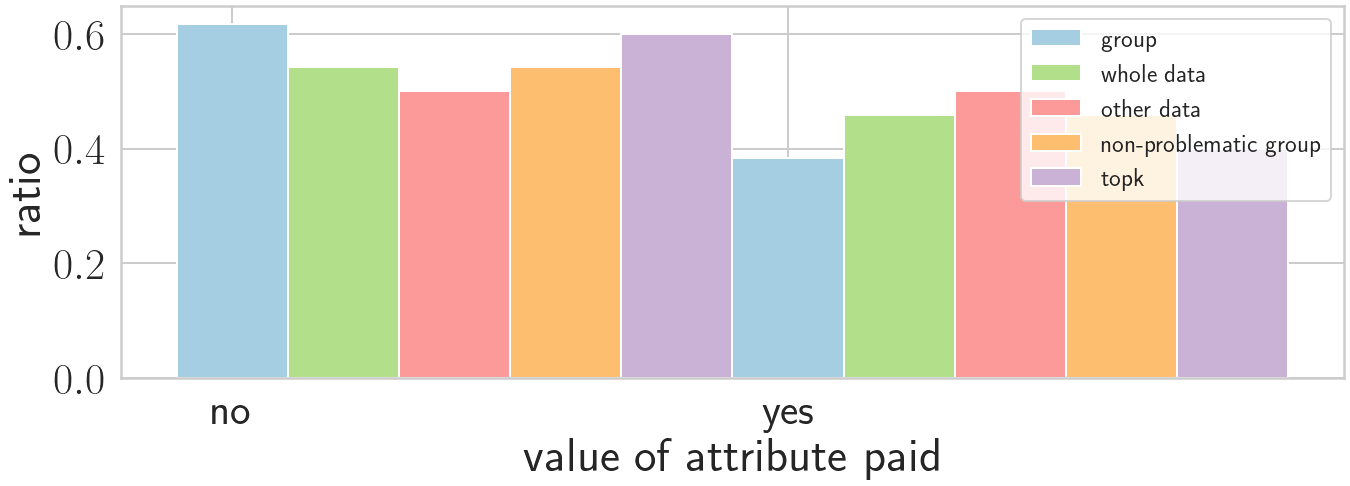

['no' 'yes']


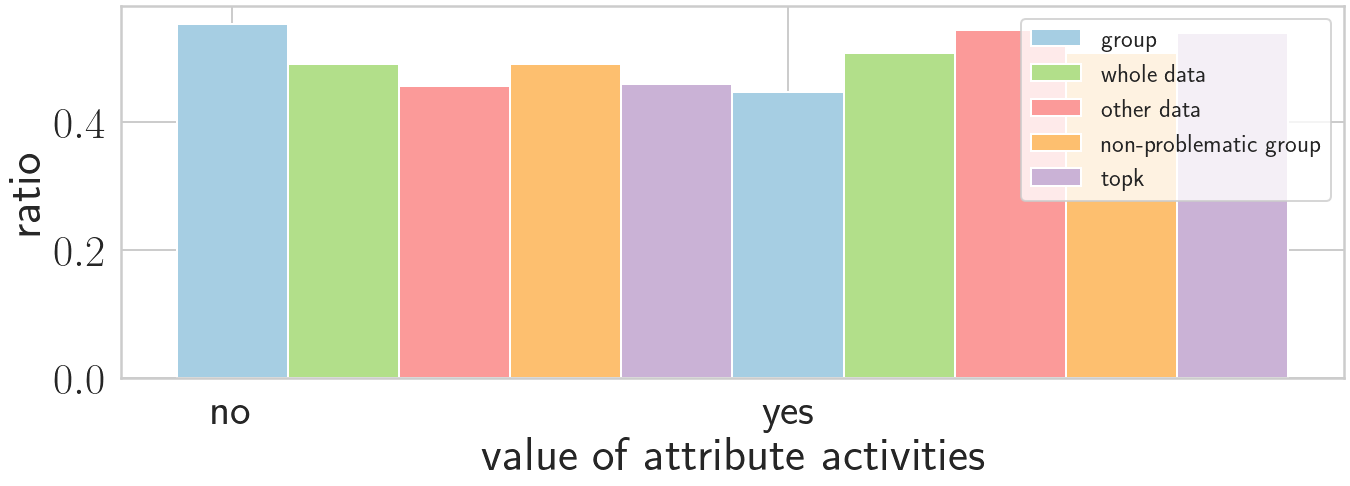

['no' 'yes']


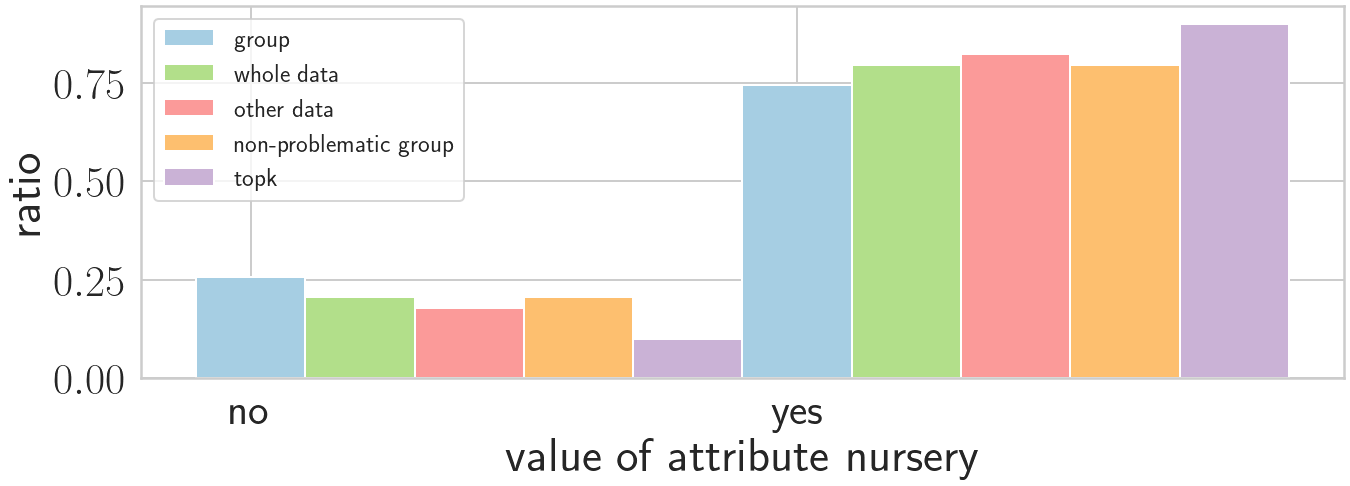

['no' 'yes']


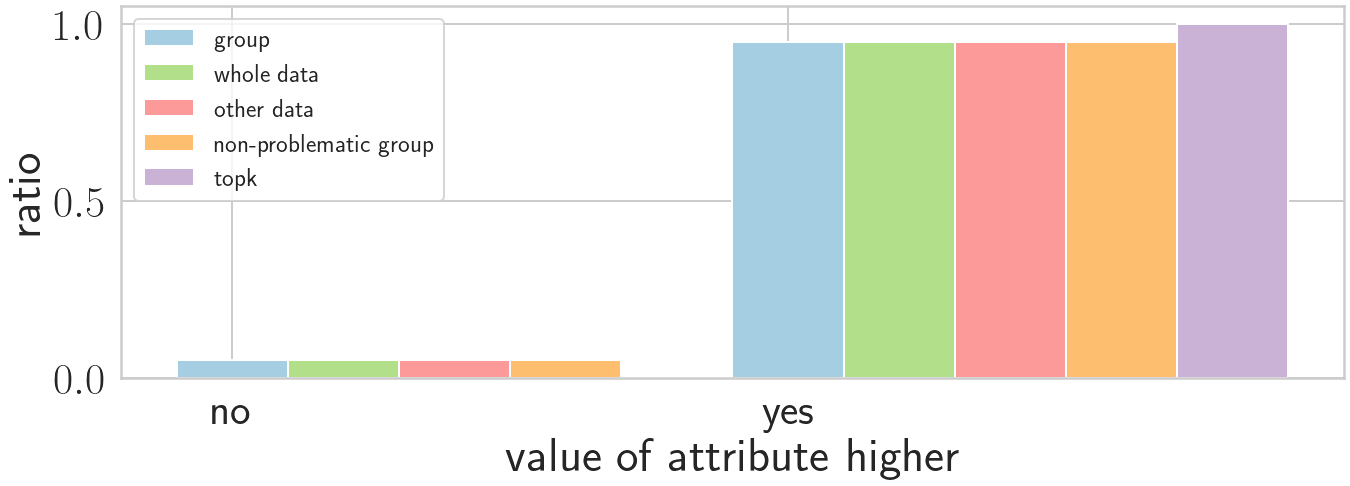

['no' 'yes']


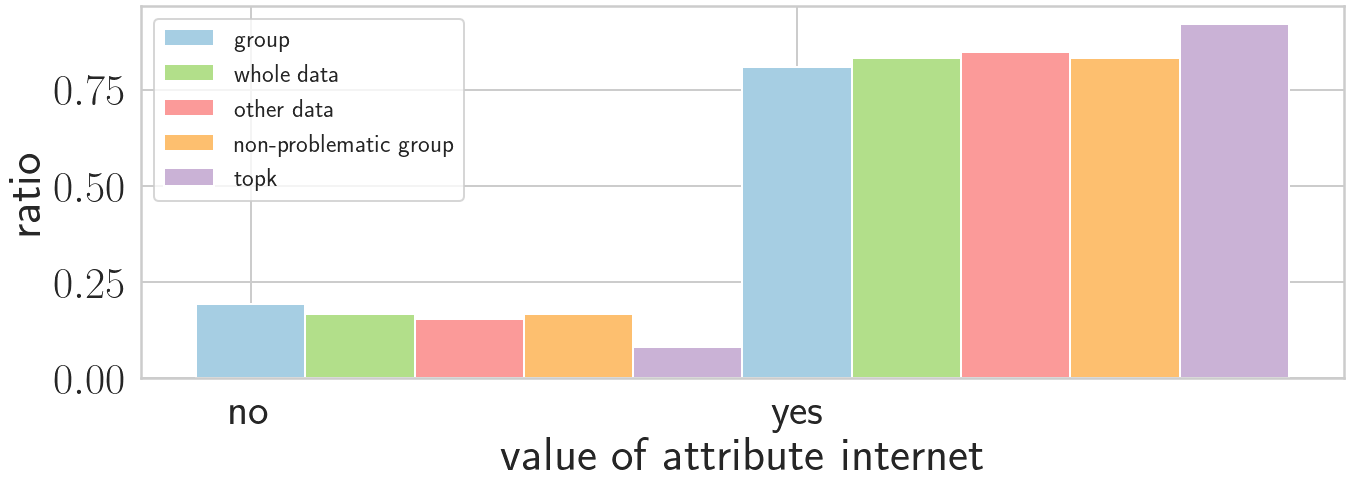

['no' 'yes']


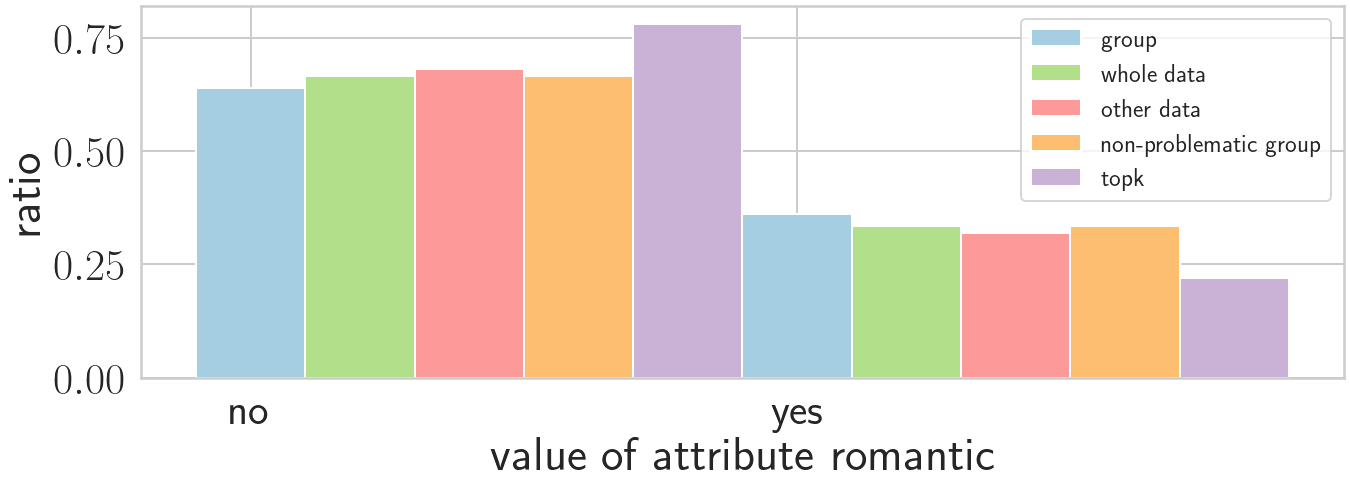

[1 2 3 4 5]


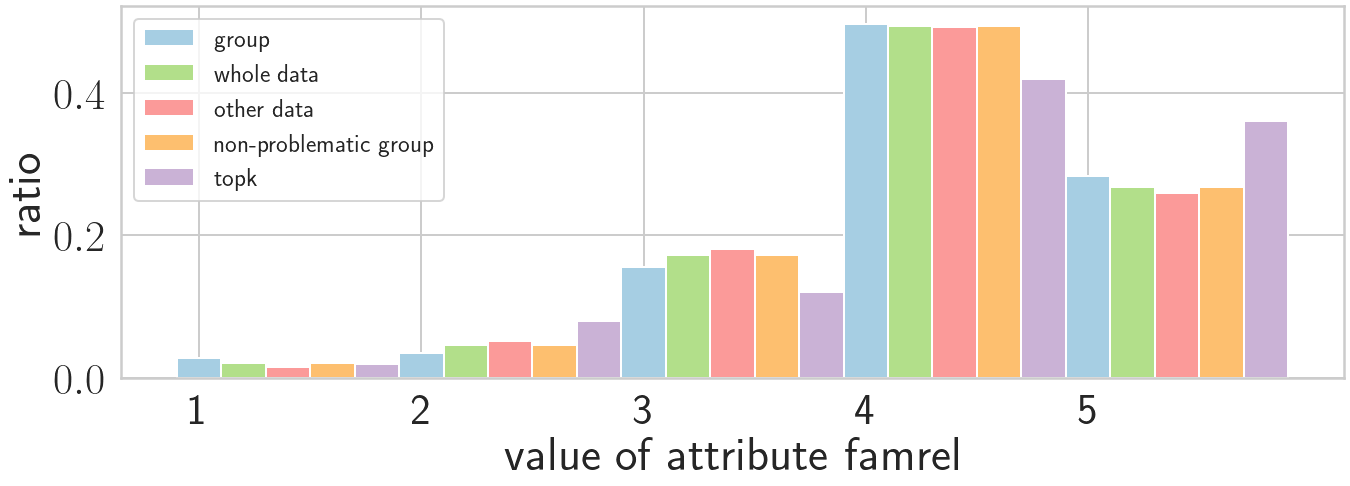

[1 2 3 4 5]


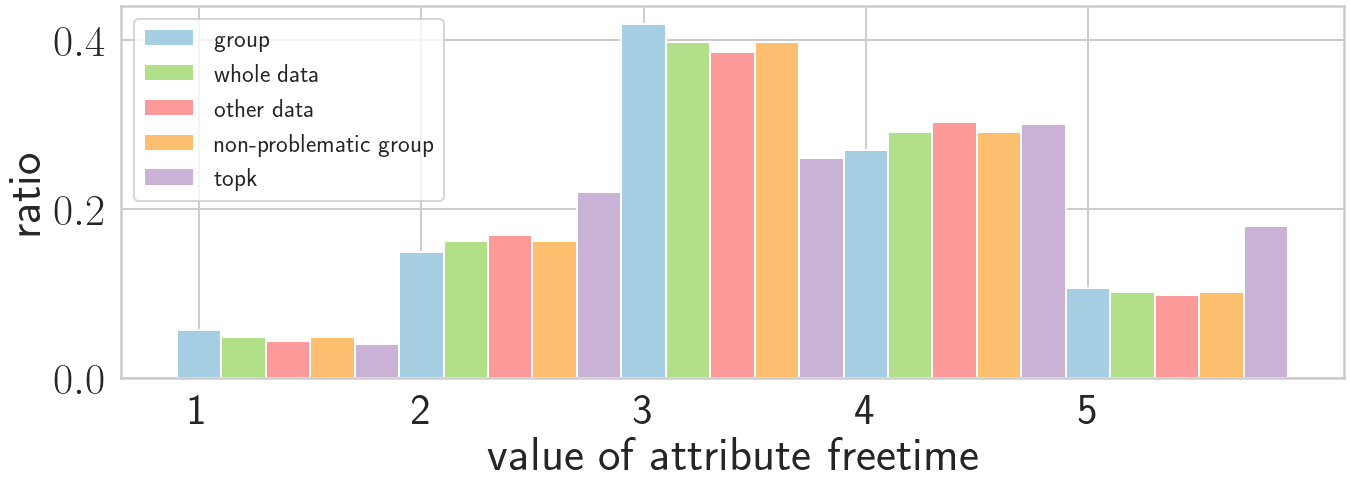

[1 2 3 4 5]


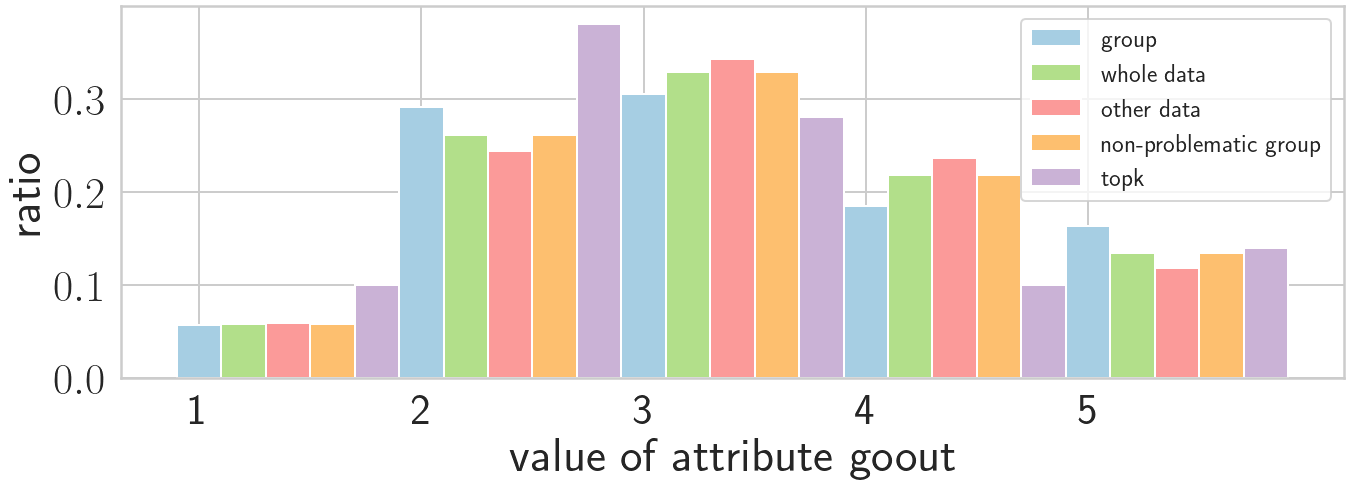

[1 2 3 4 5]


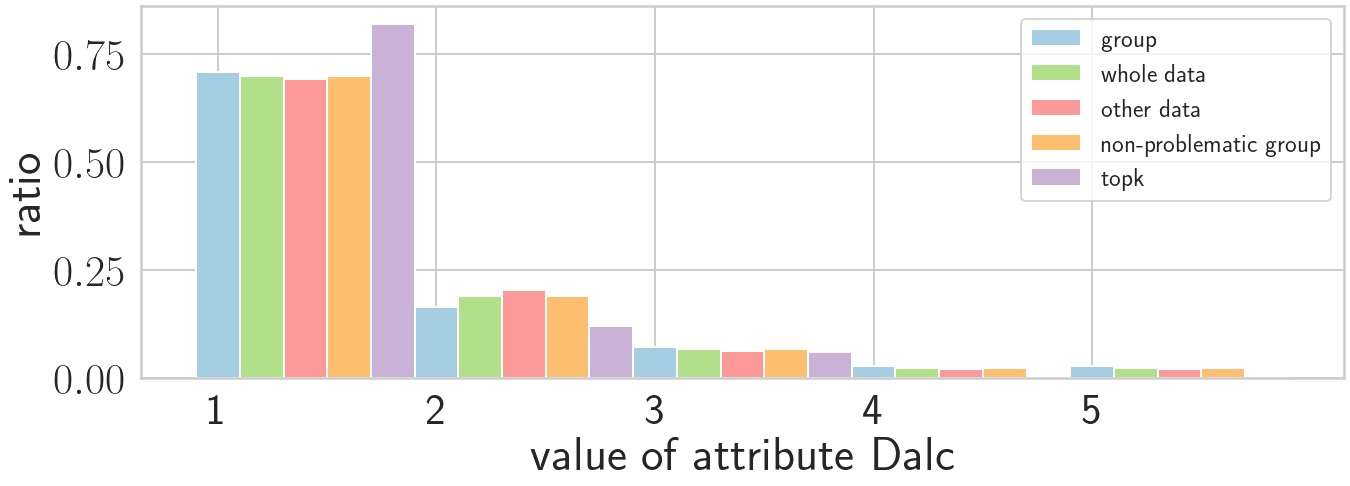

[1 2 3 4 5]


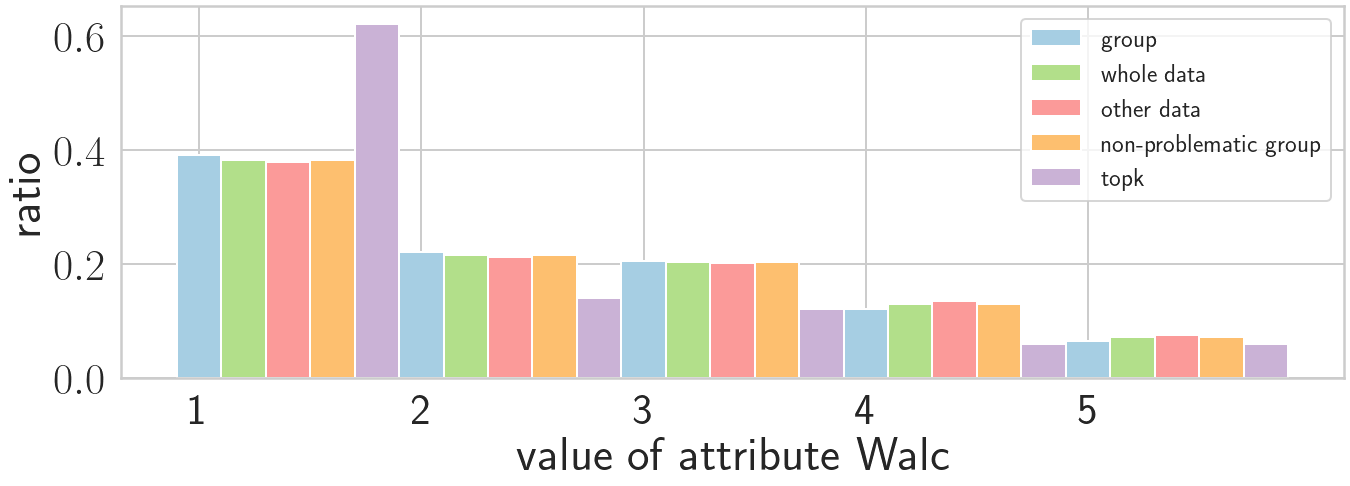

[1 2 3 4 5]


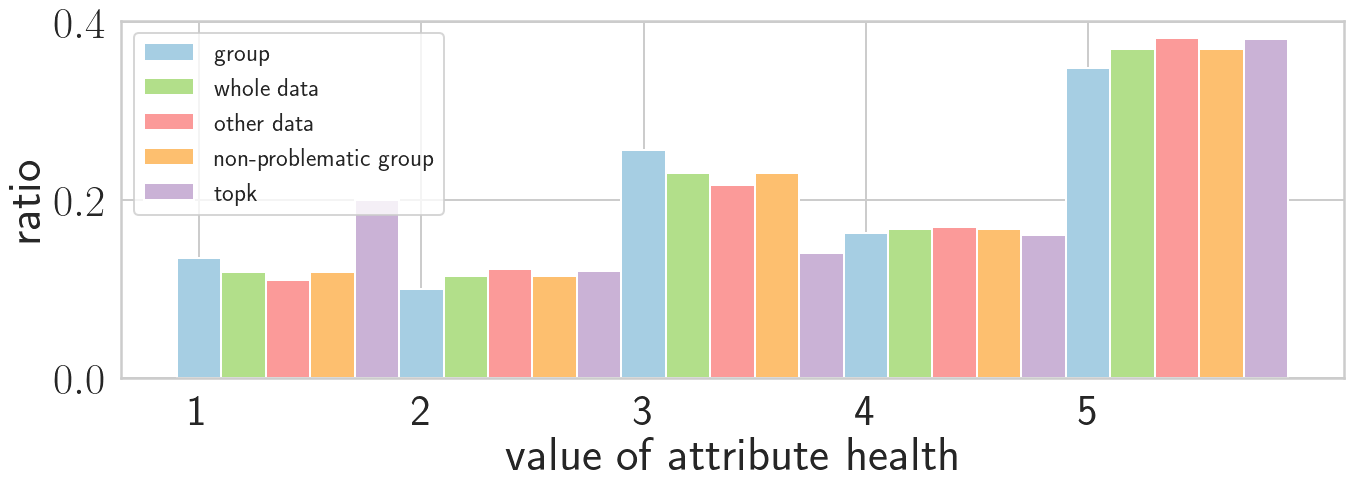

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 30 38 40 54 56 75]


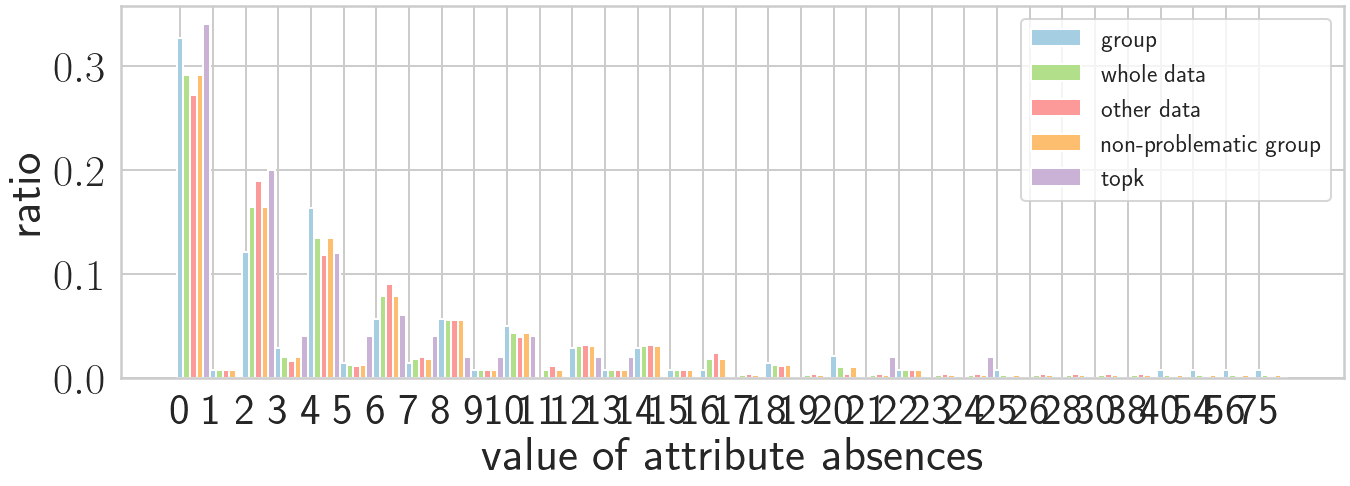

[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


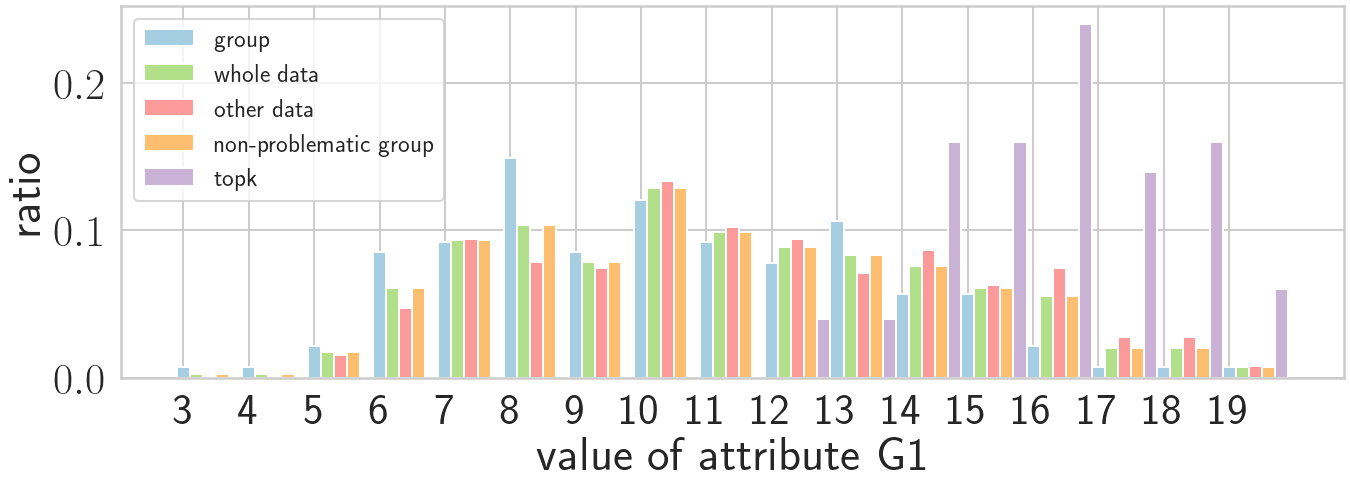

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


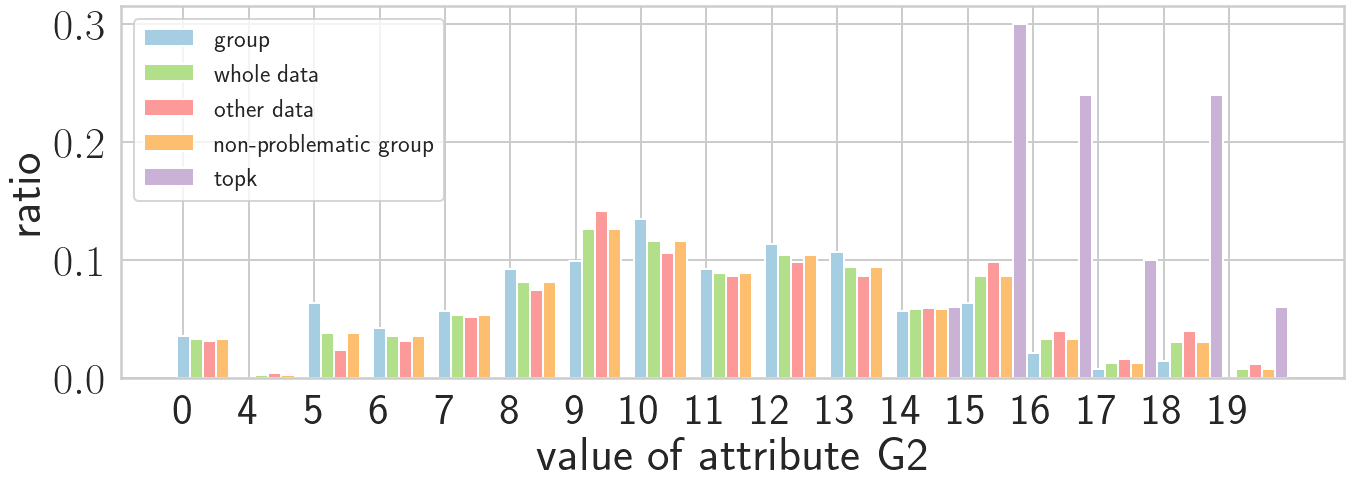

[ 0  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


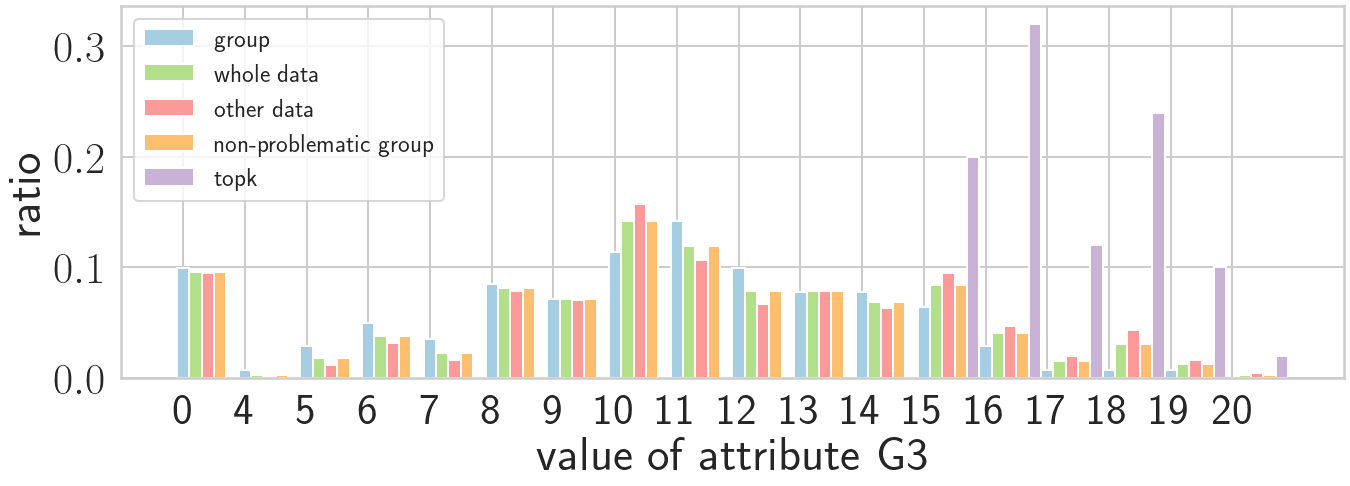

In [40]:

another_group = [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
print(check_another_group_prop_bounds(another_group, ranked_data, selected_attributes, thc, alpha, k))
for att in all_attributes_original:
    plot_distribution_ratio(ranked_data, att, groups_prop_bounds[6], another_group, k)

